In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install numpy pandas matplotlib seaborn scikit-learn xgboost joblib



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from xgboost import XGBClassifier
import joblib


In [ ]:
DATA_PATH = "D:\Minor project\AQI\delhi_combined.csv"
df = pd.read_csv(DATA_PATH)

df.head()


Timestamp              Location   PM2.5    PM10     NO2    NH3    SO2  \
0  01-01-2020  Delhi - Punjabi Bagh  420.68  507.60  105.21  63.96   6.30   
1  02-01-2020  Delhi - Punjabi Bagh  364.73  480.09   79.38  51.28   9.69   
2  03-01-2020  Delhi - Punjabi Bagh  227.72  309.23   57.22  44.29  11.04   
3  04-01-2020  Delhi - Punjabi Bagh  243.86  323.75   60.99  44.88  12.61   
4  05-01-2020  Delhi - Punjabi Bagh  161.66  222.79   56.22  38.35  11.03   

     CO     O3  
0  2.26   9.49  
1  2.87   8.03  
2  2.69   8.18  
3  1.94  11.72  
4  1.91  12.37

In [4]:
#  Timestamp conversion 
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format="%d-%m-%Y")

# Extracting the  time features
df['year'] = df['Timestamp'].dt.year
df['month'] = df['Timestamp'].dt.month
df['day'] = df['Timestamp'].dt.day
df['weekday'] = df['Timestamp'].dt.weekday

# Removing the original timestamp
df.drop(columns=['Timestamp'], inplace=True)


In [5]:
# Replacing the  negative or invalid values
pollutants = ['PM2.5', 'PM10', 'NO2', 'NH3', 'SO2', 'CO', 'O3']
df[pollutants] = df[pollutants].apply(pd.to_numeric, errors='coerce')

# Filling out the  missing values using median 
for col in pollutants:
    df[col].fillna(df[col].median(), inplace=True)


/tmp/ipykernel_47/4104543348.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


In [7]:
def calculate_aqi(row):
    return max(row['PM2.5'], row['PM10'], row['NO2'], 
               row['NH3'], row['SO2'], row['O3'])

df['AQI'] = df.apply(calculate_aqi, axis=1)


In [8]:
def aqi_category(aqi):
    if aqi <= 50:
        return 0
    elif aqi <= 100:
        return 1
    elif aqi <= 200:
        return 2
    elif aqi <= 300:
        return 3
    elif aqi <= 400:
        return 4
    else:
        return 5

df['AQI_Category'] = df['AQI'].apply(aqi_category)


In [9]:
def aqi_category(aqi):
    if aqi <= 50:
        return 0
    elif aqi <= 100:
        return 1
    elif aqi <= 200:
        return 2
    elif aqi <= 300:
        return 3
    elif aqi <= 400:
        return 4
    else:
        return 5

df['AQI_Category'] = df['AQI'].apply(aqi_category)


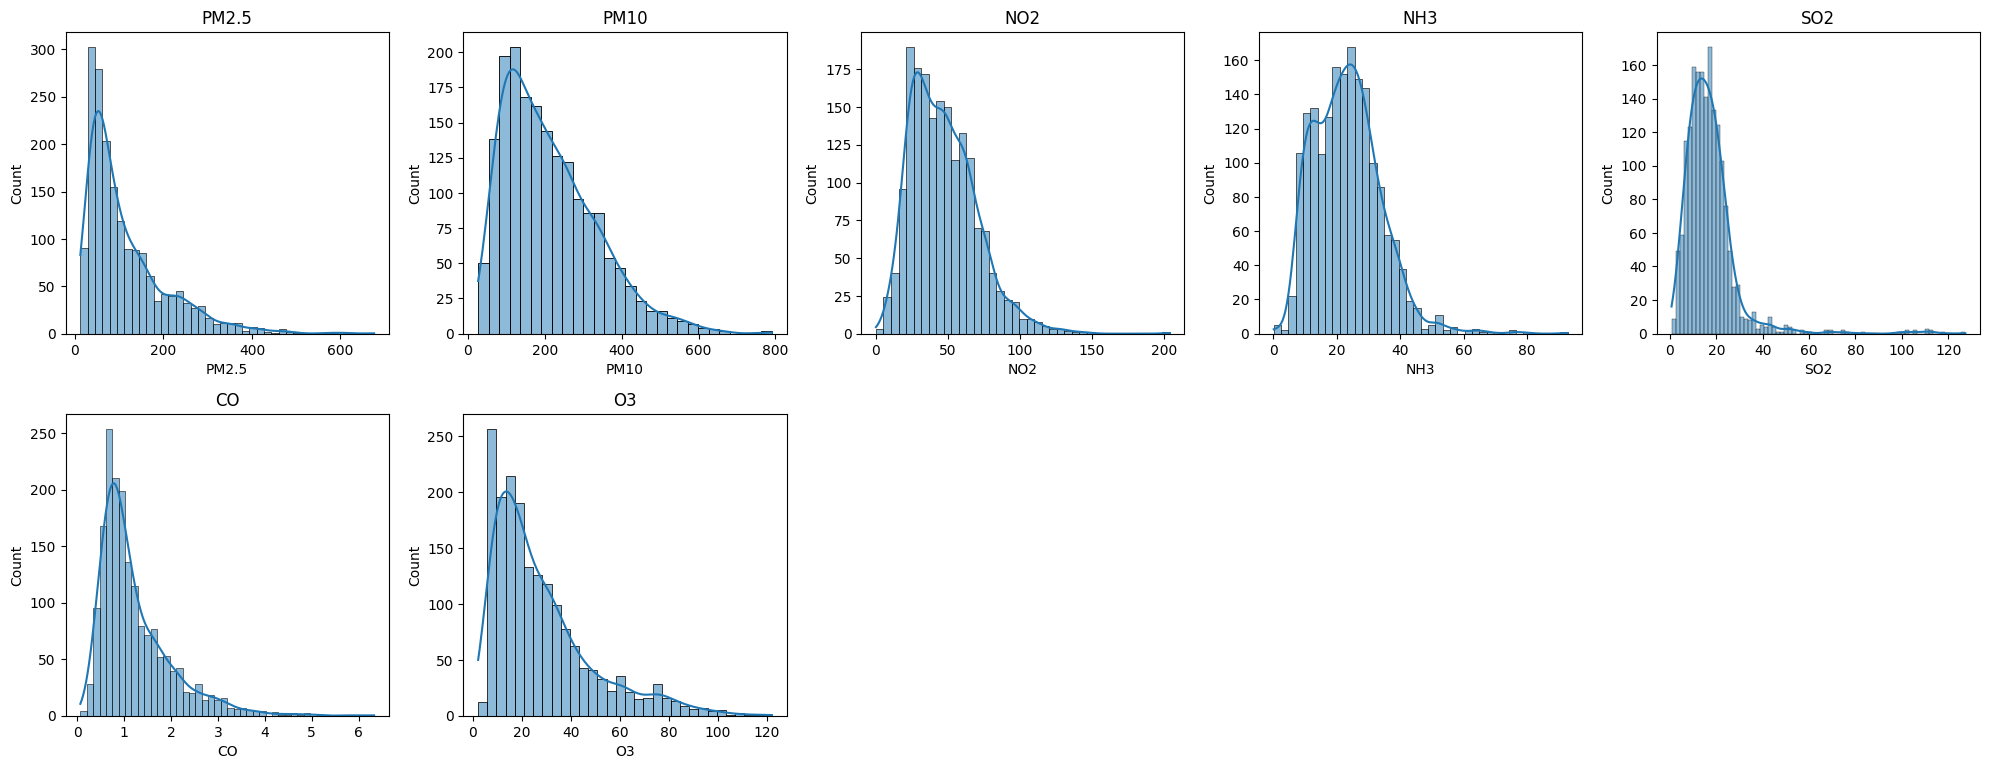

In [10]:
plt.figure(figsize=(20,15))

for i, col in enumerate(pollutants, 1):
    plt.subplot(4,5,i)
    sns.histplot(df[col], kde=True)
    plt.title(col)

plt.tight_layout()
plt.show()


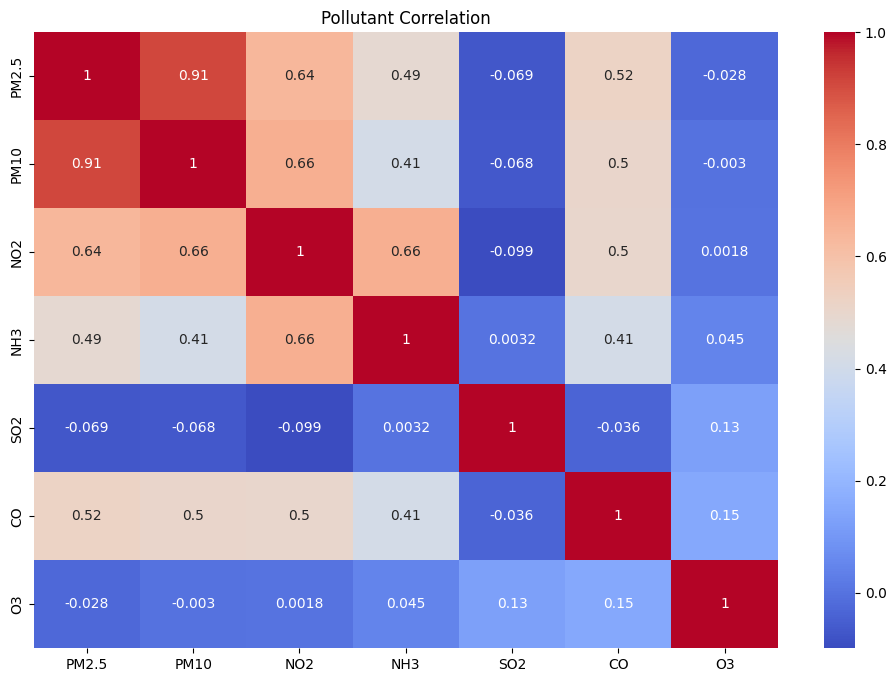

In [11]:
#   Plotting the pollution Correlation Heatmap
plt.figure(figsize=(12,8))
sns.heatmap(df[pollutants].corr(), annot=True, cmap='coolwarm')
plt.title("Pollutant Correlation")
plt.show()


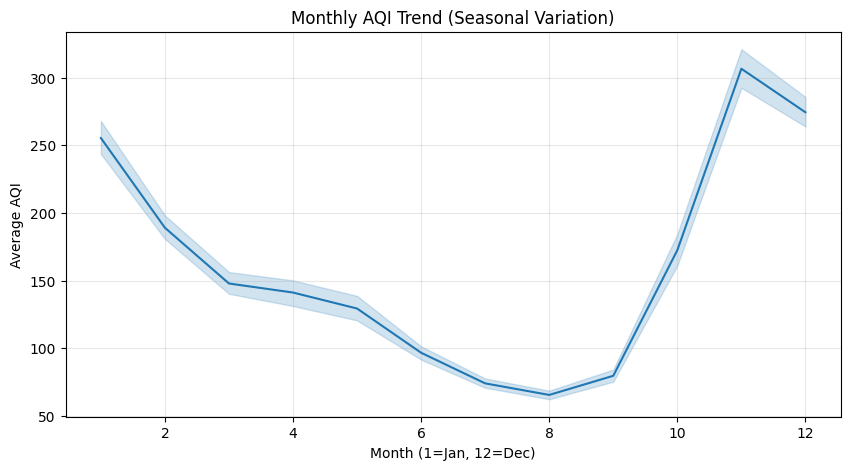

In [14]:
# Monthly AQI Trend using the engineered features
plt.figure(figsize=(10,5))
sns.lineplot(x='month', y='AQI', data=df_features)
plt.title("Monthly AQI Trend (Seasonal Variation)")
plt.xlabel("Month (1=Jan, 12=Dec)")
plt.ylabel("Average AQI")
plt.grid(True, alpha=0.3)
plt.show()

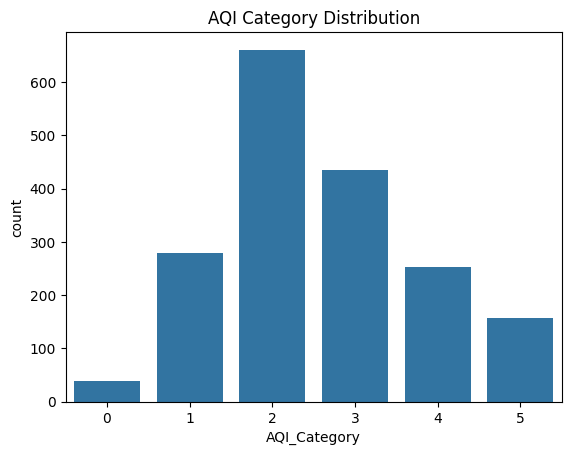

In [13]:
# AQI Category Count
sns.countplot(x='AQI_Category', data=df)
plt.title("AQI Category Distribution")
plt.show()


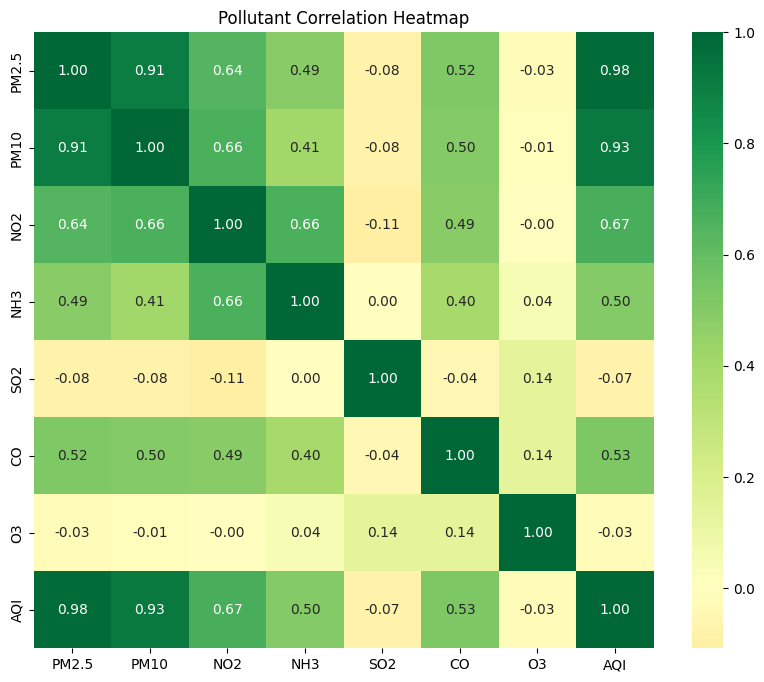

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculating the pollution   correlation matrix
pollutants = ['PM2.5', 'PM10', 'NO2', 'NH3', 'SO2', 'CO', 'O3', 'AQI']
corr_matrix = df_features[pollutants].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', center=0, fmt='.2f')
plt.title("Pollutant Correlation Heatmap")
plt.show()

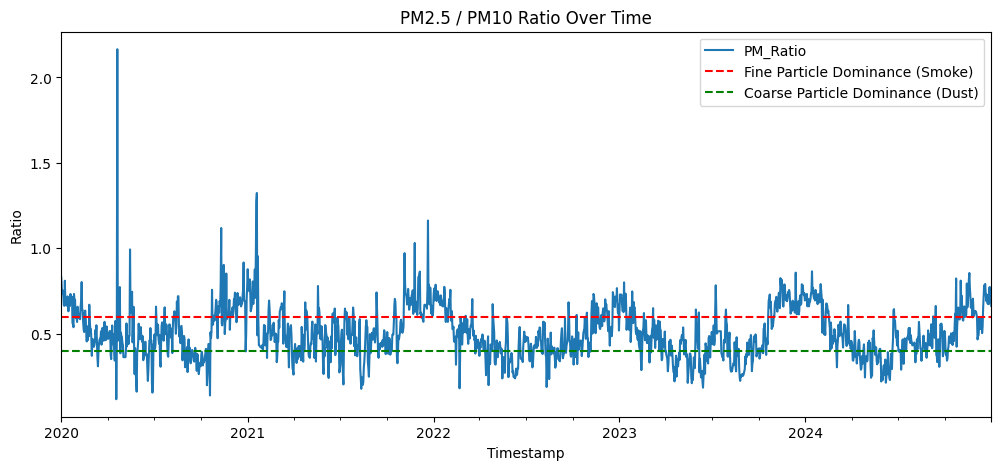

In [16]:
# Calculating the  the ratio ( PM2.5/ PM10 )
df_features['PM_Ratio'] = df_features['PM2.5'] / (df_features['PM10'] + 1e-10)

plt.figure(figsize=(12, 5))
# Plotting  the ratio over time (Daily Average)
df_features.set_index('Timestamp')['PM_Ratio'].resample('D').mean().plot()

plt.axhline(y=0.6, color='r', linestyle='--', label='Fine Particle Dominance (Smoke)')
plt.axhline(y=0.4, color='g', linestyle='--', label='Coarse Particle Dominance (Dust)')
plt.title("PM2.5 / PM10 Ratio Over Time")
plt.ylabel("Ratio")
plt.legend()
plt.show()

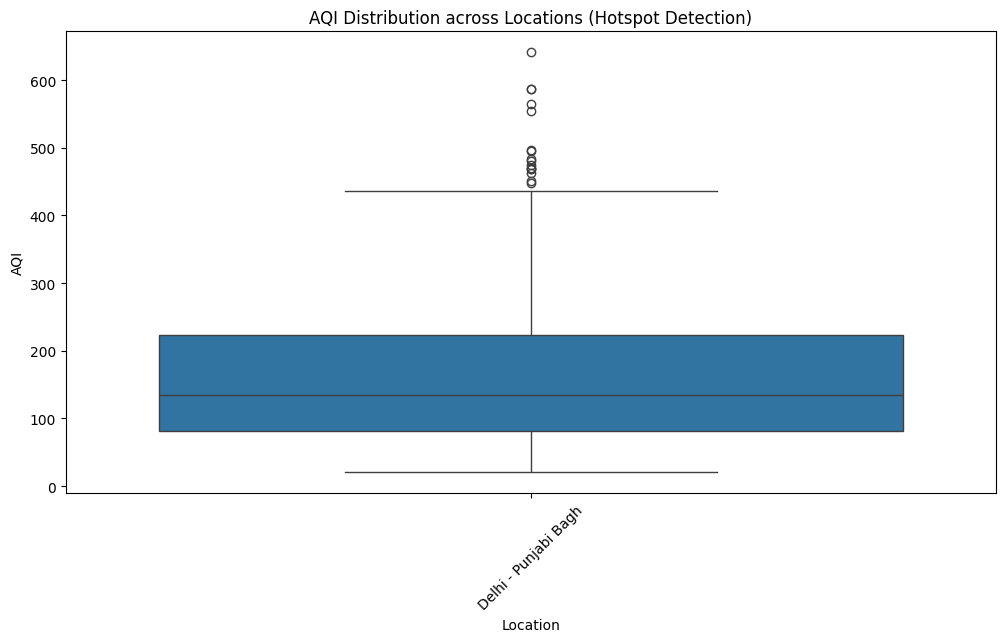

In [17]:
plt.figure(figsize=(12, 6))
# Sorting the  locations by average AQI
location_order = df_features.groupby('Location')['AQI'].mean().sort_values(ascending=False).index

sns.boxplot(x='Location', y='AQI', data=df_features, order=location_order)
plt.xticks(rotation=45)
plt.title("AQI Distribution across Locations (Hotspot Detection)")
plt.show()

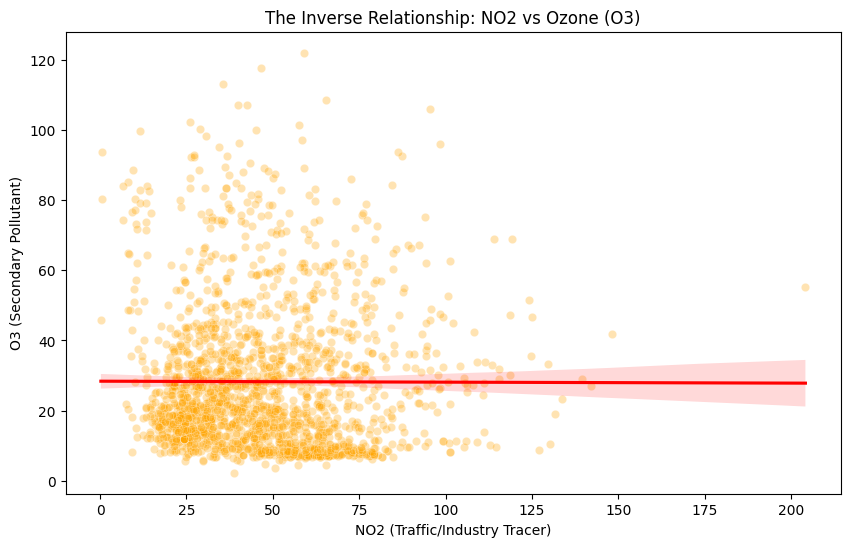

In [18]:
plt.figure(figsize=(10, 6))
# Scatter plot for  inverse relationship
sns.scatterplot(x='NO2', y='O3', data=df_features, alpha=0.3, color='orange')

# Trend line
sns.regplot(x='NO2', y='O3', data=df_features, scatter=False, color='red')

plt.title("The Inverse Relationship: NO2 vs Ozone (O3)")
plt.xlabel("NO2 (Traffic/Industry Tracer)")
plt.ylabel("O3 (Secondary Pollutant)")
plt.show()

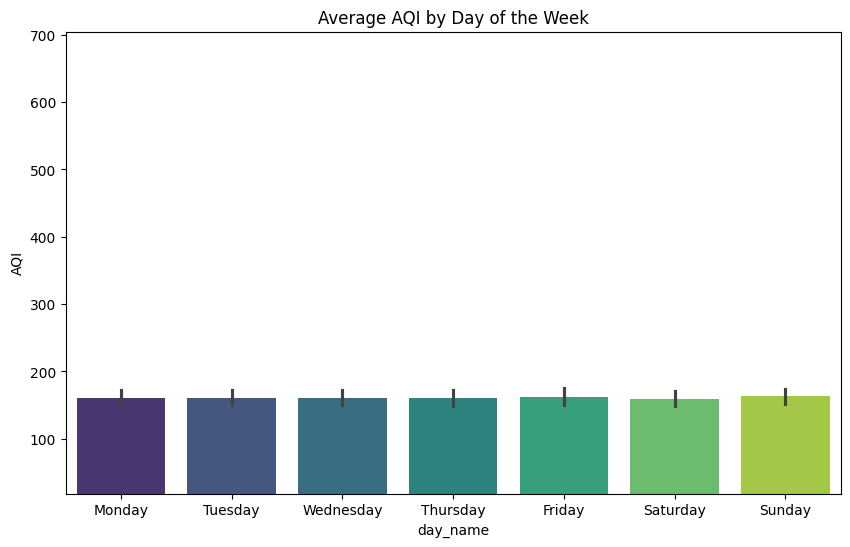

In [19]:
# Group by day of week
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_features['day_name'] = df_features['Timestamp'].dt.day_name()

plt.figure(figsize=(10, 6))
sns.barplot(x='day_name', y='AQI', data=df_features, order=day_names, palette='viridis')
plt.title("Average AQI by Day of the Week")
plt.ylim(df_features['AQI'].min() * 0.9, df_features['AQI'].max() * 1.1) # Zoom in to see difference
plt.show()

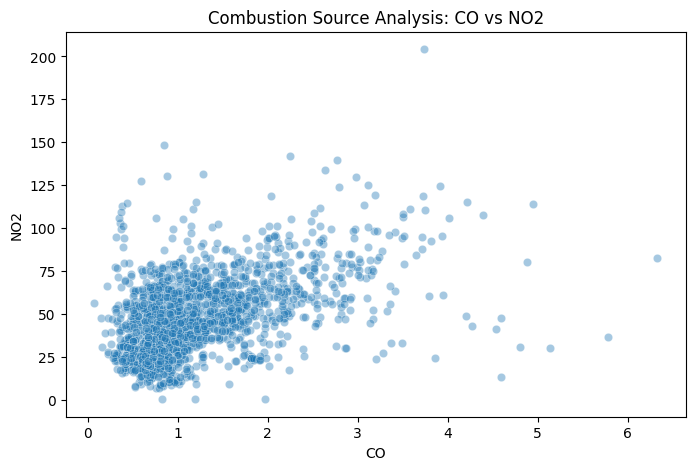

In [20]:
#plotting Combustion Source Analysis CO /NO2
plt.figure(figsize=(8, 5))
sns.scatterplot(x='CO', y='NO2', data=df_features, alpha=0.4)
plt.title("Combustion Source Analysis: CO vs NO2")
plt.show()

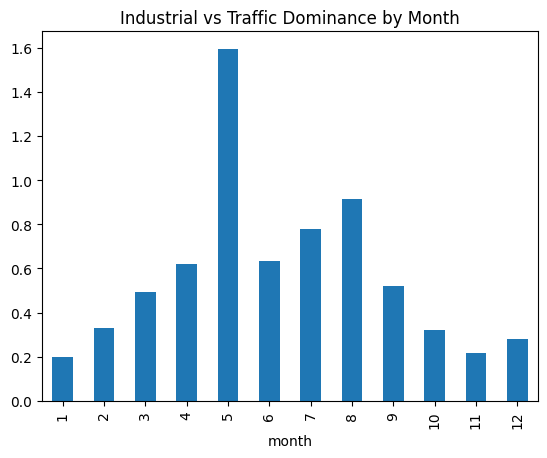

In [21]:
#comparing industrial vs Traffic for AQI production 
df_features['SO2_NO2_Ratio'] = df_features['SO2'] / (df_features['NO2'] + 1e-5)
df_features.groupby('month')['SO2_NO2_Ratio'].mean().plot(kind='bar')
plt.title("Industrial vs Traffic Dominance by Month")
plt.show()

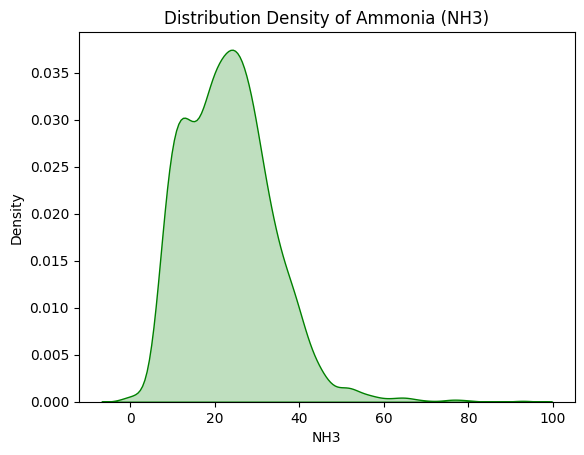

In [22]:
# plotting the NH3 Distribution 
sns.kdeplot(df_features['NH3'], fill=True, color='green')
plt.title("Distribution Density of Ammonia (NH3)")
plt.show()

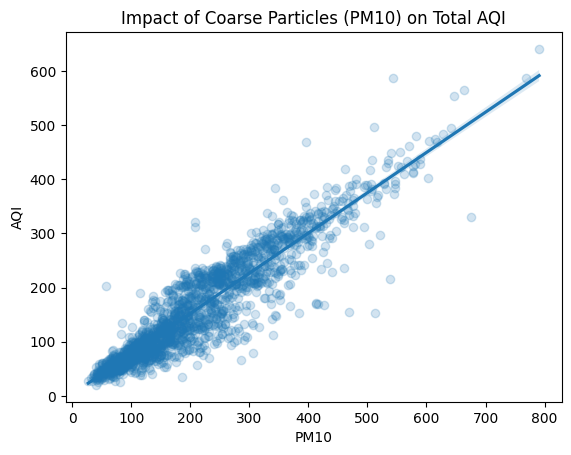

In [23]:
#Plotting Impact of PM10
sns.regplot(x='PM10', y='AQI', data=df_features, scatter_kws={'alpha':0.2})
plt.title("Impact of Coarse Particles (PM10) on Total AQI")
plt.show()

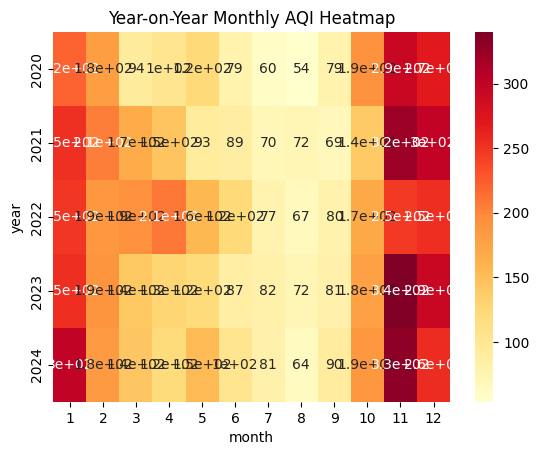

In [25]:
#plotting the Year Vs year 
pivot_table = df_features.pivot_table(values='AQI', index='year', columns='month', aggfunc='mean')
sns.heatmap(pivot_table, annot=True, cmap='YlOrRd')
plt.title("Year-on-Year Monthly AQI Heatmap")
plt.show()

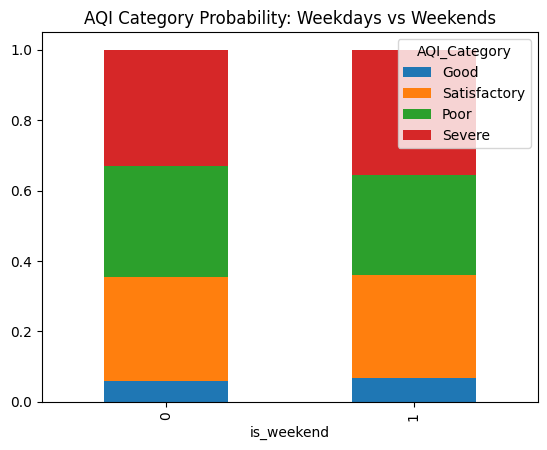

In [26]:
#plotting the Weekdays vs weekend AQI plot
df_features['AQI_Category'] = pd.cut(df_features['AQI'], bins=[0, 50, 100, 200, 500], labels=['Good', 'Satisfactory', 'Poor', 'Severe'])
pd.crosstab(df_features['is_weekend'], df_features['AQI_Category'], normalize='index').plot(kind='bar', stacked=True)
plt.title("AQI Category Probability: Weekdays vs Weekends")
plt.show()

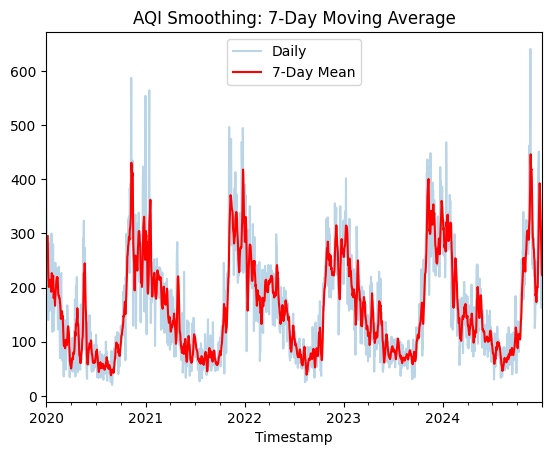

In [27]:
#Plotting the AQI over 7 days 

df_features.set_index('Timestamp')['AQI'].plot(alpha=0.3, label='Daily')
df_features.set_index('Timestamp')['AQI'].rolling(window=7).mean().plot(label='7-Day Mean', color='red')
plt.legend()
plt.title("AQI Smoothing: 7-Day Moving Average")
plt.show()

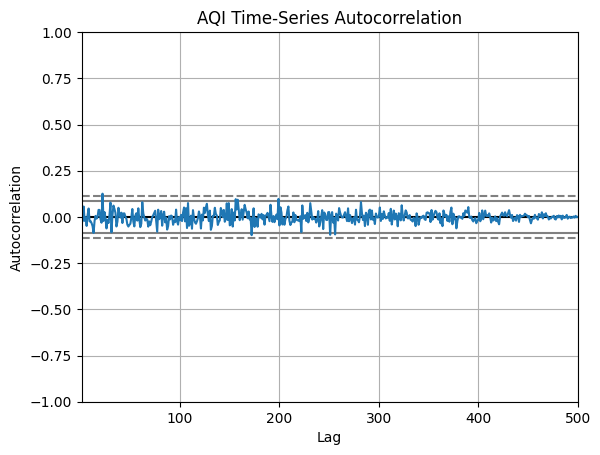

In [28]:
#plotting the AQI Time Seris Correlation

from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df_features['AQI'].sample(500))
plt.title("AQI Time-Series Autocorrelation")
plt.show()

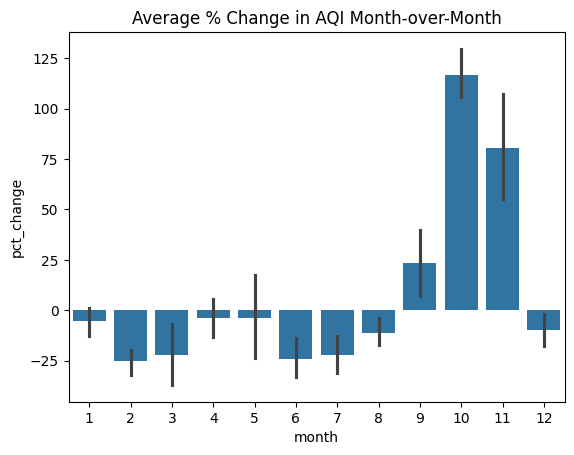

In [29]:
#percentage change in AQI over various months 
monthly_aqi = df_features.groupby(['year', 'month'])['AQI'].mean().reset_index()
monthly_aqi['pct_change'] = monthly_aqi['AQI'].pct_change() * 100
sns.barplot(x='month', y='pct_change', data=monthly_aqi)
plt.title("Average % Change in AQI Month-over-Month")
plt.show()

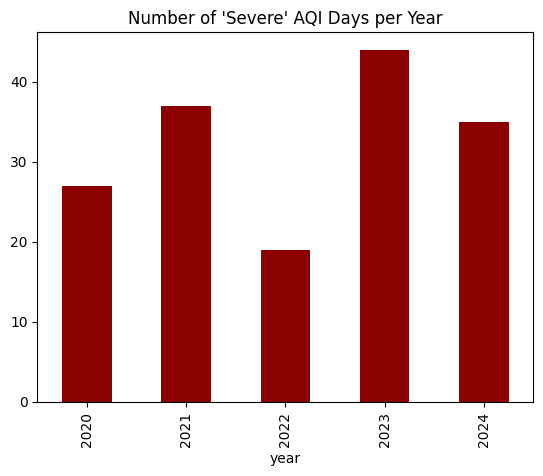

In [30]:
#AQI days (severe)/year 

severe_days = df_features[df_features['AQI'] > 300].groupby('year').size()
severe_days.plot(kind='bar', color='darkred')
plt.title("Number of 'Severe' AQI Days per Year")
plt.show()

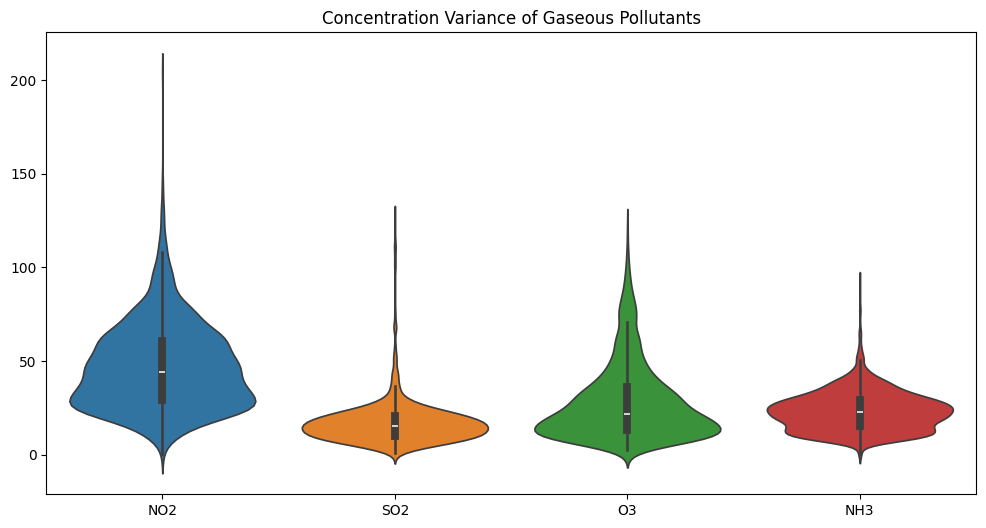

In [31]:
#plotting the Conc. of Gaseous pllutants 
plt.figure(figsize=(12, 6))
sns.violinplot(data=df_features[['NO2', 'SO2', 'O3', 'NH3']])
plt.title("Concentration Variance of Gaseous Pollutants")
plt.show()

In [32]:
from scipy import stats
df_features['z_score'] = np.abs(stats.zscore(df_features['AQI']))
outliers = df_features[df_features['z_score'] > 3]
print(f"Number of extreme pollution outliers: {len(outliers)}")

Number of extreme pollution outliers: 15


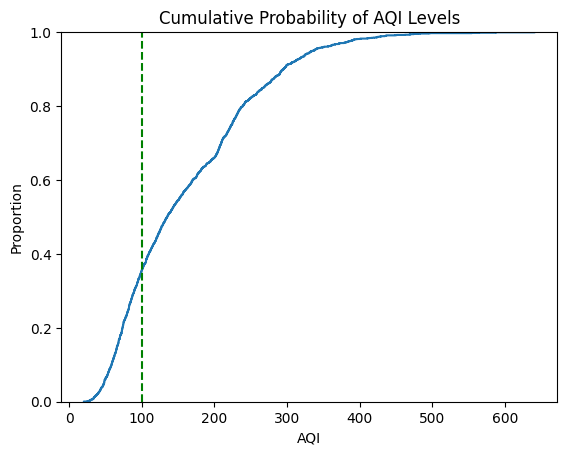

In [33]:
# AQI laevel probability 
sns.ecdfplot(data=df_features, x='AQI')
plt.axvline(100, color='g', linestyle='--')
plt.title("Cumulative Probability of AQI Levels")
plt.show()

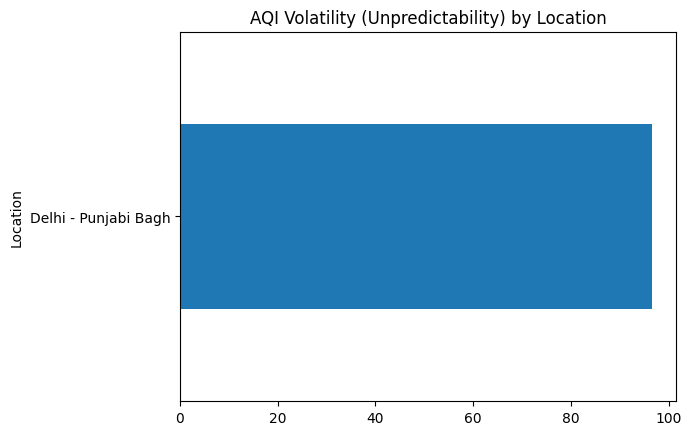

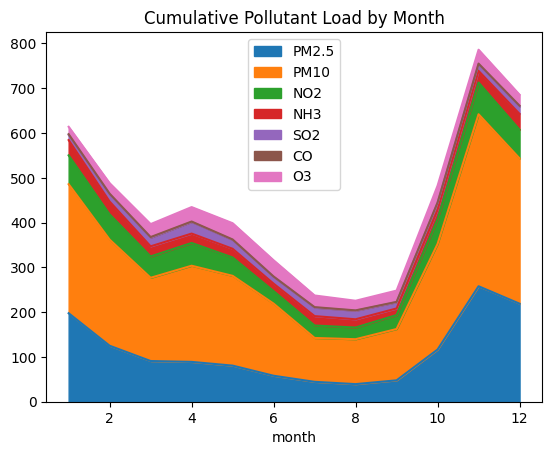

In [35]:
#predicting the AQI volatility 

df_features.groupby('Location')['AQI'].std().sort_values().plot(kind='barh')
plt.title("AQI Volatility (Unpredictability) by Location")
plt.show()


# Plotting Cumulative Pollutant Load by Month

df_features.groupby('month')[pollutants[:-1]].mean().plot(kind='area', stacked=True)
plt.title("Cumulative Pollutant Load by Month")
plt.show()



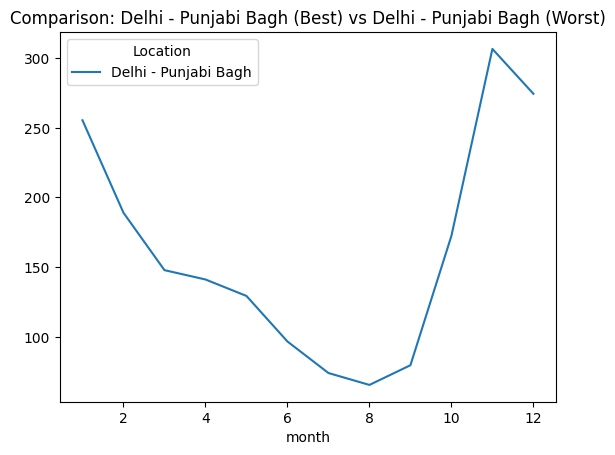

In [36]:
#plotting the Best vs Worst 

best = df_features.groupby('Location')['AQI'].mean().idxmin()
worst = df_features.groupby('Location')['AQI'].mean().idxmax()
df_features[df_features['Location'].isin([best, worst])].groupby(['Location', 'month'])['AQI'].mean().unstack(0).plot()
plt.title(f"Comparison: {best} (Best) vs {worst} (Worst)")
plt.show()

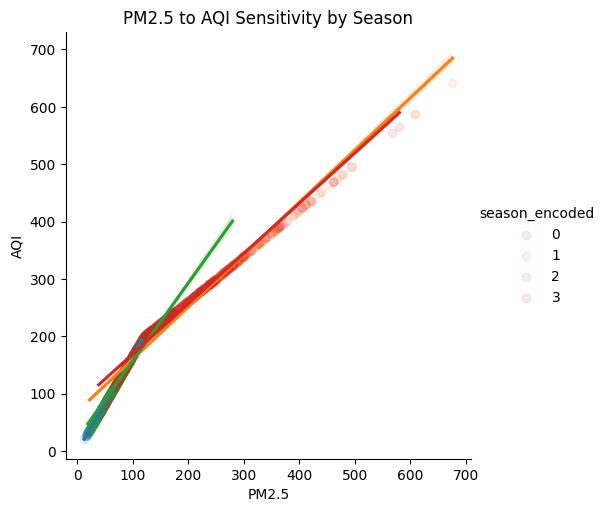

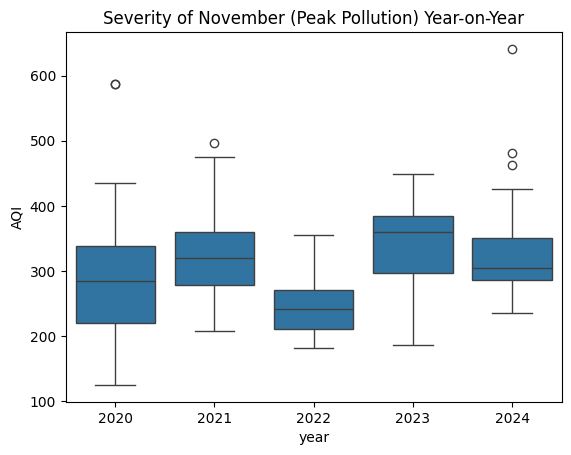

In [42]:
# PM2.5 vs AQI sensetivity 

sns.lmplot(x='PM2.5', y='AQI', hue='season_encoded', data=df_features, scatter_kws={'alpha':0.1})
plt.title("PM2.5 to AQI Sensitivity by Season")
plt.show()


#pollution of peak time 
nov_data = df_features[df_features['month'] == 11]
sns.boxplot(x='year', y='AQI', data=nov_data)
plt.title("Severity of November (Peak Pollution) Year-on-Year")
plt.show()

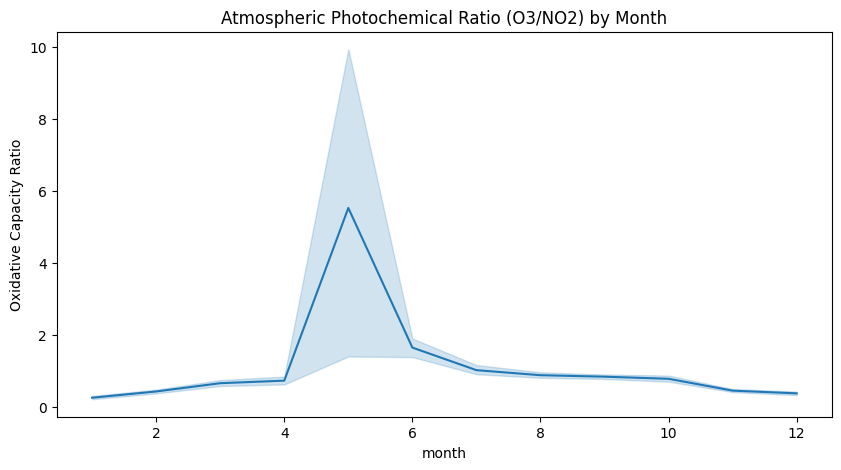

In [43]:
# Assuming NOx is approximated by NO2 
df_features['O3_NO2_Ratio'] = df_features['O3'] / (df_features['NO2'] + 1e-5)
plt.figure(figsize=(10, 5))
sns.lineplot(x='month', y='O3_NO2_Ratio', data=df_features)
plt.title("Atmospheric Photochemical Ratio (O3/NO2) by Month")
plt.ylabel("Oxidative Capacity Ratio")
plt.show()

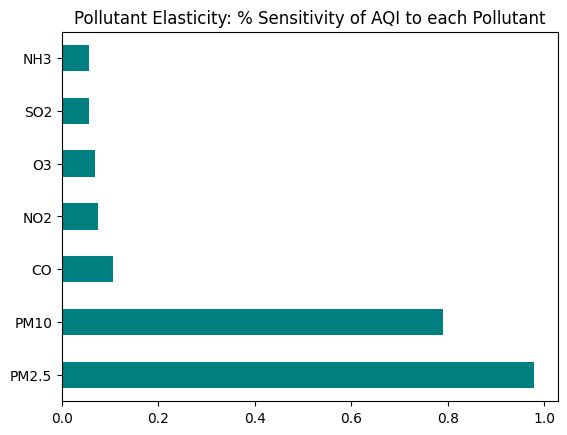

In [44]:
# Plotting the pollutant elasticity
elasticity = df_features[pollutants].pct_change().corr()['AQI'].sort_values(ascending=False)
elasticity.drop('AQI').plot(kind='barh', color='teal')
plt.title("Pollutant Elasticity: % Sensitivity of AQI to each Pollutant")
plt.show()

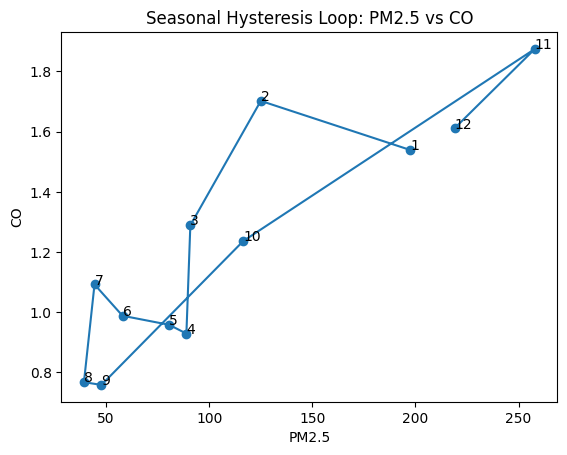

In [45]:
# Group by hour  or by Month to see seasonal loops
pivot = df_features.groupby('month')[['PM2.5', 'CO']].mean()
plt.plot(pivot['PM2.5'], pivot['CO'], marker='o')
for i, m in enumerate(pivot.index):
    plt.annotate(m, (pivot['PM2.5'].iloc[i], pivot['CO'].iloc[i]))
plt.xlabel('PM2.5'); plt.ylabel('CO')
plt.title("Seasonal Hysteresis Loop: PM2.5 vs CO")
plt.show()

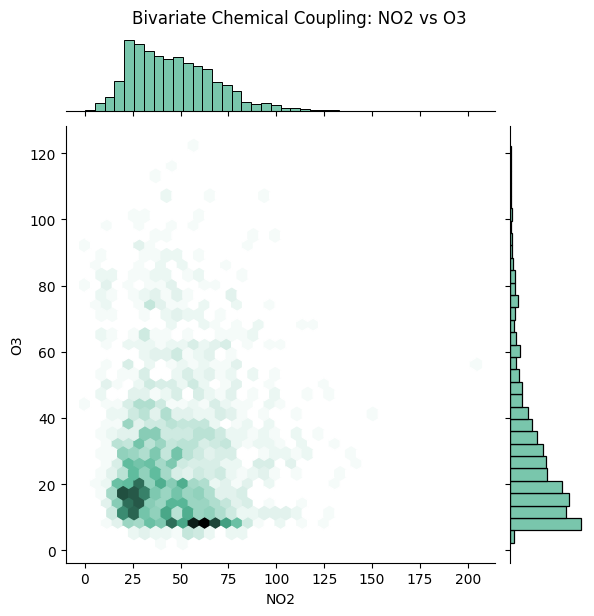

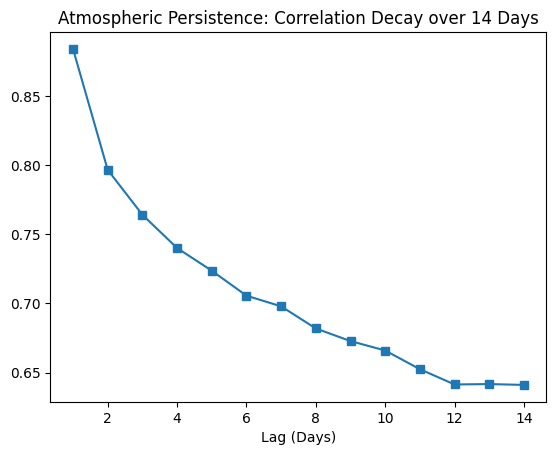

In [49]:
#chemical Coupling 
sns.jointplot(x='NO2', y='O3', data=df_features, kind="hex", color="#4CB391")
plt.suptitle("Bivariate Chemical Coupling: NO2 vs O3", y=1.02)
plt.show()



# Simple version: Lag correlation decay
lags = [df_features['AQI'].corr(df_features['AQI'].shift(i)) for i in range(1, 15)]
plt.plot(range(1, 15), lags, marker='s')
plt.title("Atmospheric Persistence: Correlation Decay over 14 Days")
plt.xlabel("Lag (Days)")
plt.show()

In [50]:
from scipy.stats import entropy
# Calculate entropy of the AQI distribution
aqi_dist = np.histogram(df_features['AQI'], bins=50, density=True)[0]
print(f"Atmospheric Uncertainty (Shannon Entropy): {entropy(aqi_dist):.4f}")

Atmospheric Uncertainty (Shannon Entropy): 3.2603


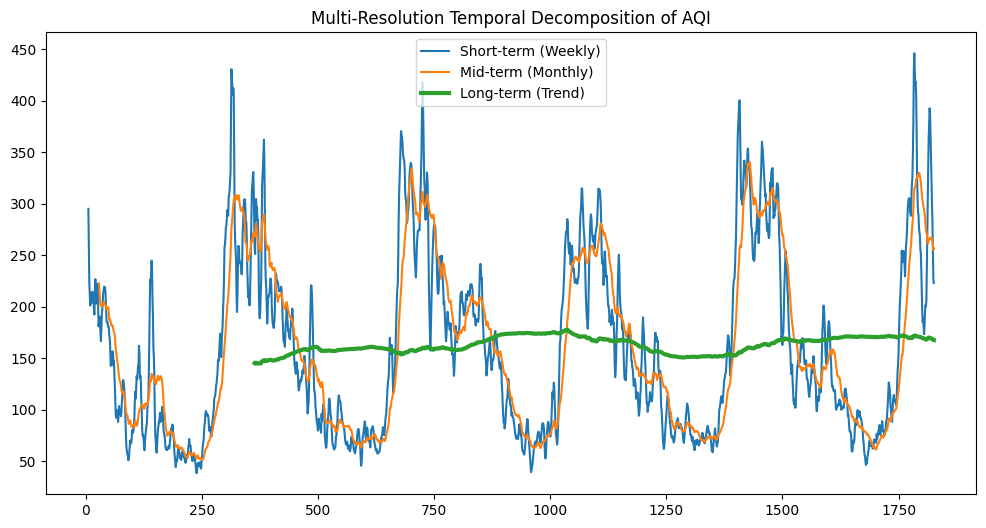

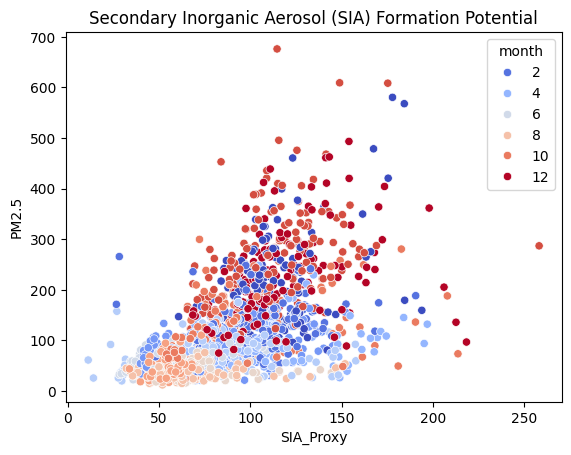

In [52]:
# Plotting different rolling windows as a proxy for wavelet levels
plt.figure(figsize=(12,6))
plt.plot(df_features['AQI'].rolling(7).mean(), label='Short-term (Weekly)')
plt.plot(df_features['AQI'].rolling(30).mean(), label='Mid-term (Monthly)')
plt.plot(df_features['AQI'].rolling(365).mean(), label='Long-term (Trend)', lw=3)
plt.title("Multi-Resolution Temporal Decomposition of AQI")
plt.legend()
plt.show()


#plotting (SIA) Formation Potential
df_features['SIA_Proxy'] = df_features['NH3'] + df_features['SO2'] + df_features['NO2']
sns.scatterplot(x='SIA_Proxy', y='PM2.5', hue='month', data=df_features, palette='coolwarm')
plt.title("Secondary Inorganic Aerosol (SIA) Formation Potential")
plt.show()

In [53]:
import plotly.graph_objects as go
import numpy as np


x = np.linspace(df_features['PM2.5'].min(), df_features['PM2.5'].max(), 20)
y = np.linspace(df_features['NO2'].min(), df_features['NO2'].max(), 20)
X, Y = np.meshgrid(x, y)

Z = (X * 0.5) + (Y * 0.8) 

fig = go.Figure(data=[go.Surface(z=Z, x=x, y=y, colorscale='Viridis')])
fig.update_layout(title='3D AQI Response Surface', scene=dict(
    xaxis_title='PM2.5', yaxis_title='NO2', zaxis_title='AQI'))
fig.show()

In [54]:
import plotly.express as px
fig = px.scatter_3d(df_features, x='PM2.5', y='CO', z='O3', color='AQI', 
                    title="3D Pollutant Clustering & Fingerprinting")
fig.show()

In [56]:
fig = px.line_3d(df_features, x='month', y='AQI', z='year', color='Location')
fig.update_layout(title="Seasonal Pollution Spiral (2020-2024)")
fig.show()

In [58]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
components = pca.fit_transform(df_features[features])
fig = px.scatter_3d(components, x=0, y=1, z=2, color=df_features['AQI'],
                    labels={'0': 'PC1', '1': 'PC2', '2': 'PC3'})
fig.show()

In [60]:
fig = go.Figure(data=go.Contour(
    z=df_features['O3'], x=df_features['NO2'], y=df_features['month']
)) 
fig.show()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.3/132.3 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for calplot: filename=calplot-0.1.7.5-py3-none-any.whl size=8115 sha256=2b0e7c9ef73648dbf72aa55c22727921c415929dcb1e38a7f814b8a157e96ab4
  Stored in directory: /root/.cache/pip/wheels/f1/eb/af/79f8750a9f757aa0ccb6a0e217515abf3892f989345e98e50c
Successfully built calplot


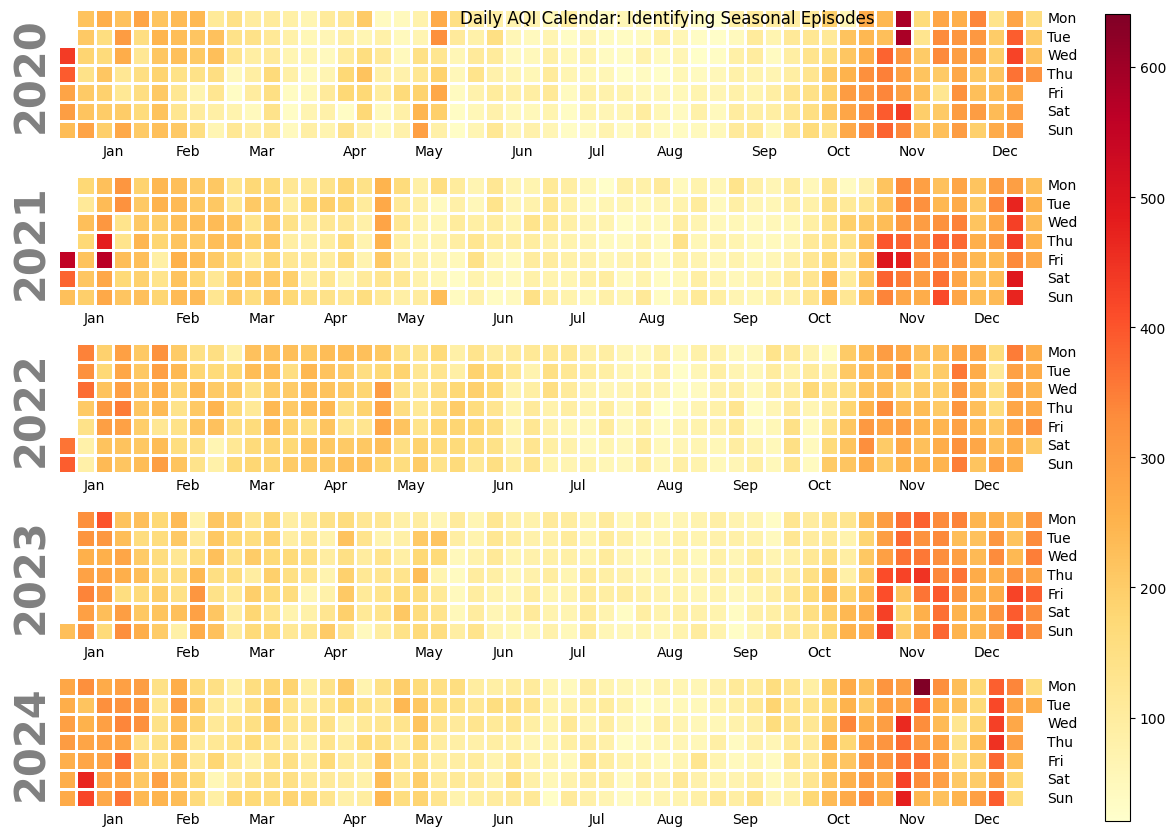

In [70]:
!pip install calplot
import calplot
#  index is Timestamp
df_features.set_index('Timestamp', inplace=True)
calplot.calplot(df_features['AQI'], cmap='YlOrRd', edgecolor=None, yearlabels=True)
plt.suptitle("Daily AQI Calendar: Identifying Seasonal Episodes")
plt.show()

In [63]:
import plotly.express as px

fig = px.bar_polar(df_features, r="PM2.5", theta="month", color="AQI",
                   template="plotly_dark", title="Monthly Polar Distribution of PM2.5")
fig.show()

In [64]:
import plotly.express as px
fig = px.parallel_coordinates(df_features, dimensions=['PM2.5', 'NO2', 'SO2', 'CO', 'AQI'],
                              color="AQI", color_continuous_scale=px.colors.diverging.Tealrose)
fig.show()

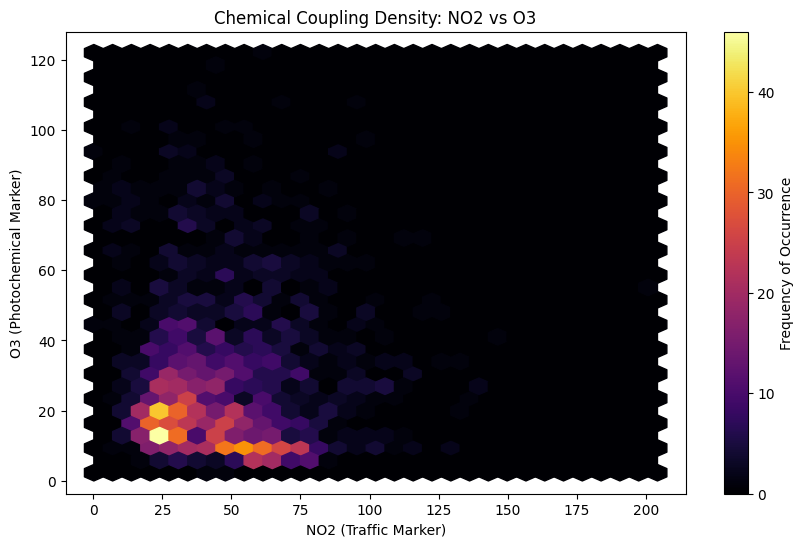

In [65]:
#Chemical Coupling 
plt.figure(figsize=(10, 6))
plt.hexbin(df_features['NO2'], df_features['O3'], gridsize=30, cmap='inferno')
plt.colorbar(label='Frequency of Occurrence')
plt.xlabel('NO2 (Traffic Marker)')
plt.ylabel('O3 (Photochemical Marker)')
plt.title("Chemical Coupling Density: NO2 vs O3")
plt.show()

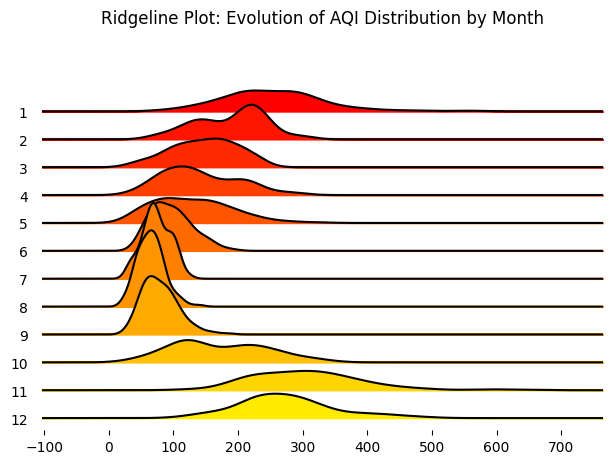

In [69]:
#Evolution of AQI 
!pip install joypy
from joypy import joyplot
fig, axes = joyplot(df_features, by="month", column="AQI", colormap=plt.cm.autumn, 
                    title="Ridgeline Plot: Evolution of AQI Distribution by Month")

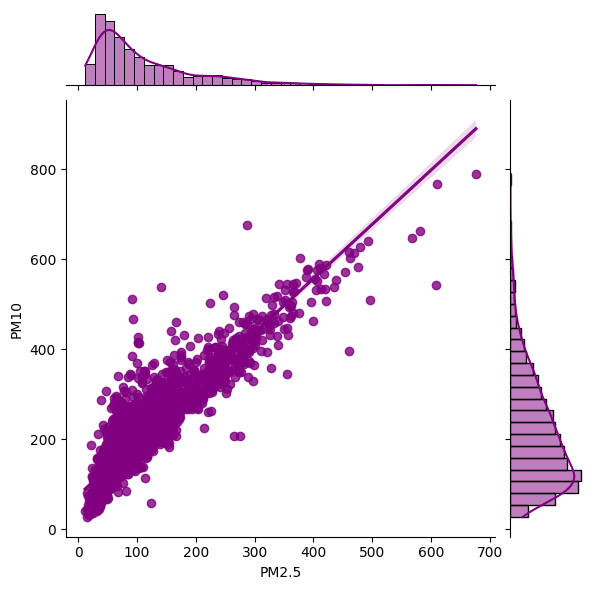

In [67]:
sns.jointplot(data=df_features, x="PM2.5", y="PM10", kind="reg", color="purple")

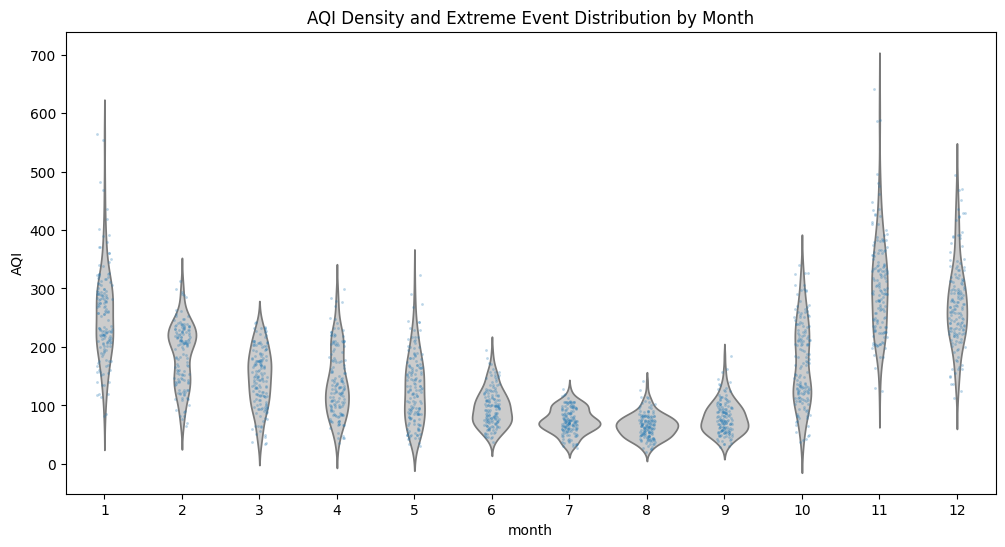

In [68]:
#AQI density 
plt.figure(figsize=(12, 6))
sns.violinplot(x='month', y='AQI', data=df_features, inner=None, color=".8")
sns.stripplot(x='month', y='AQI', data=df_features, size=2, jitter=True, alpha=0.3)
plt.title("AQI Density and Extreme Event Distribution by Month")
plt.show()

Pollutant Mixture Composition


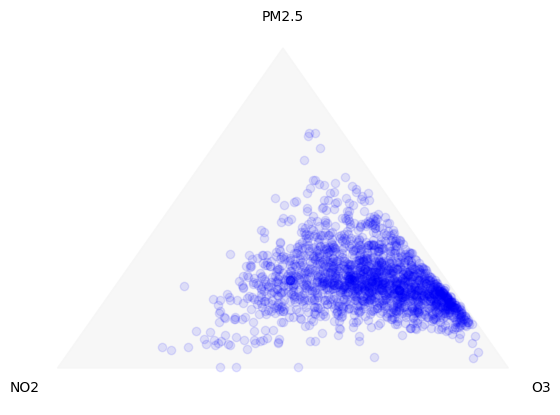

In [74]:
 !pip install python-ternary
import ternary
print ("Pollutant Mixture Composition")
# Normalize data to sum to 100
df_tern = df_features[['PM2.5', 'NO2', 'O3']].copy()
df_tern = df_tern.div(df_tern.sum(axis=1), axis=0)

fig, tax = ternary.figure(scale=100)
tax.scatter(df_tern.values * 100, color="blue", marker='o', alpha=0.1)
tax.top_corner_label("PM2.5")
tax.left_corner_label("NO2")
tax.right_corner_label("O3")
tax.get_axes().axis('off')

tax.show()

In [75]:
import plotly.express as px
fig = px.sunburst(df_features, path=['season', 'month', 'Location'], values='AQI',
                  color='AQI', color_continuous_scale='RdYlGn_r')
fig.update_layout(title_text="Hierarchical AQI Structure")
fig.show()

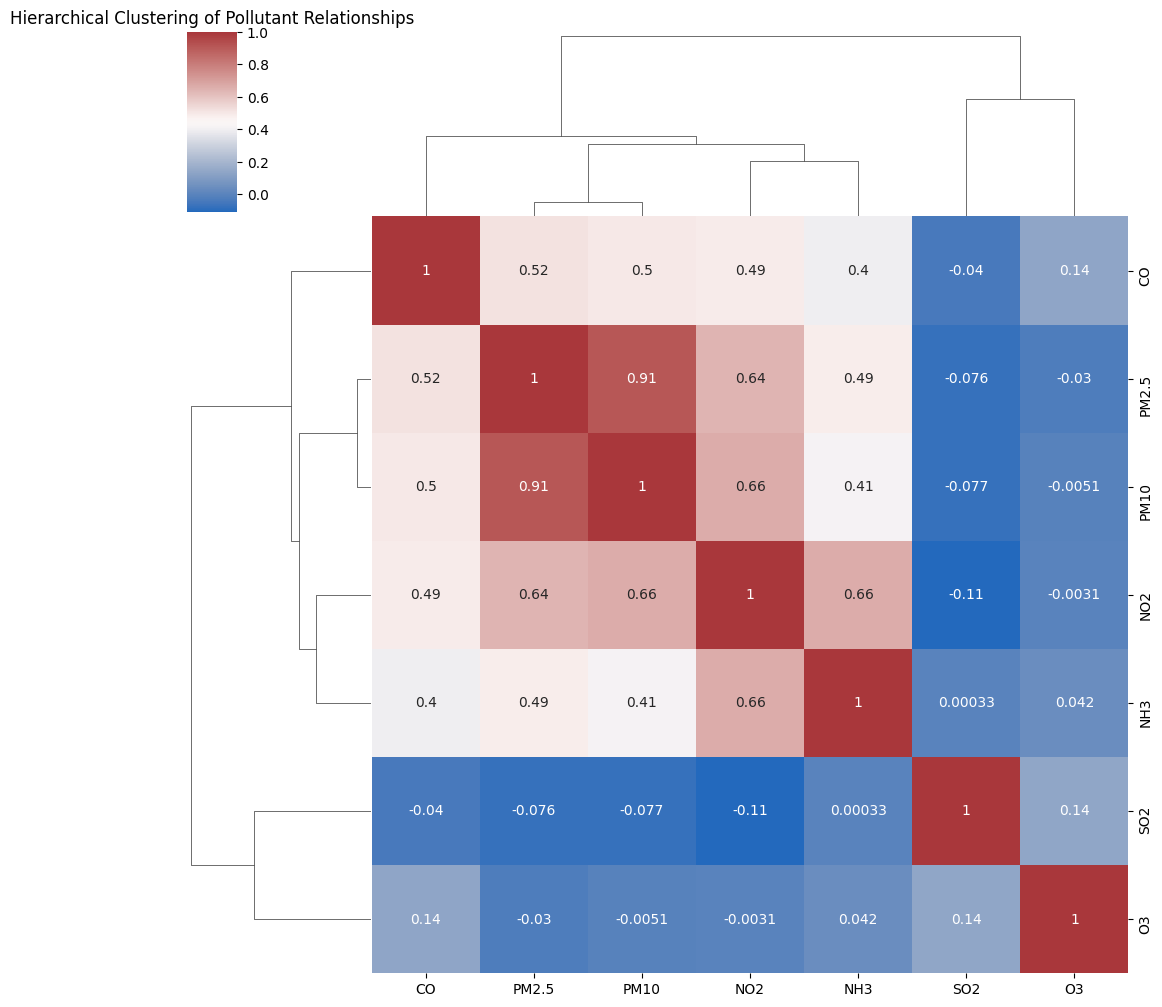

In [76]:
import seaborn as sns
# Correlation of pollutants over time
pollutant_cols = ['PM2.5', 'PM10', 'NO2', 'NH3', 'SO2', 'CO', 'O3']
sns.clustermap(df_features[pollutant_cols].corr(), annot=True, cmap='vlag')
plt.title("Hierarchical Clustering of Pollutant Relationships")
plt.show()

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
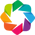

:Chord   [source,target]   (value)

In [77]:
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')

corr = df_features[pollutant_cols].corr().stack().reset_index()
corr.columns = ['source', 'target', 'value']
chord = hv.Chord(corr[corr['value'] > 0.7]) # Only show strong links
chord.opts(opts.Chord(cmap='Category10', edge_color='source', labels='index'))

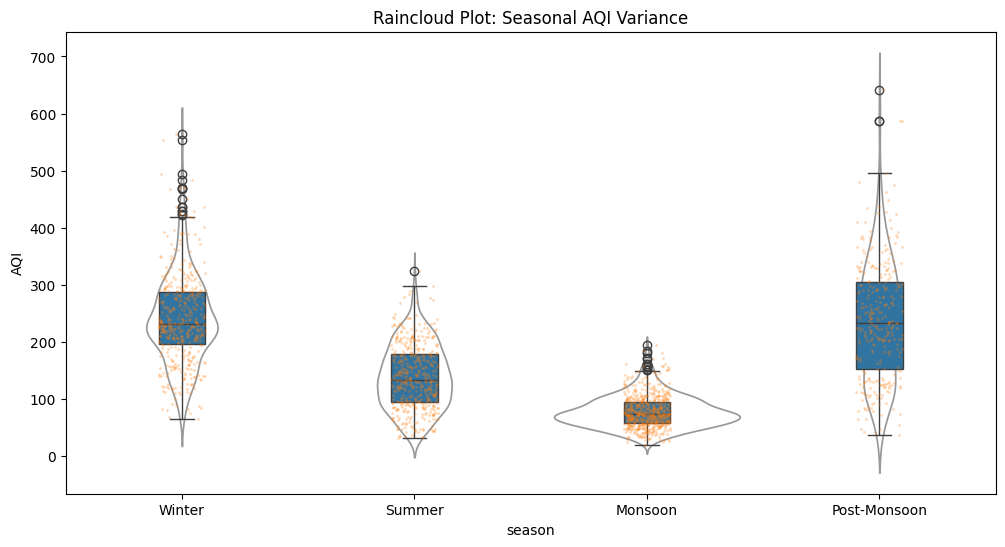

In [79]:
import seaborn as sns
plt.figure(figsize=(12,6))
sns.violinplot(x='season', y='AQI', data=df_features, inner=None, color="white")
sns.boxplot(x='season', y='AQI', data=df_features, width=0.2, boxprops={'zorder': 2})
sns.stripplot(x='season', y='AQI', data=df_features, size=2, alpha=0.3, jitter=True)
plt.title("Raincloud Plot: Seasonal AQI Variance")
plt.show()

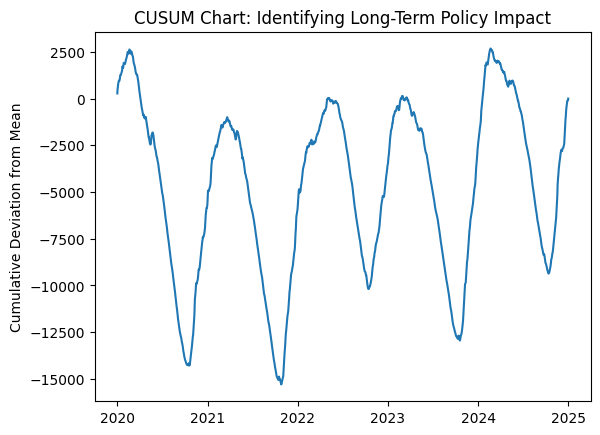

In [81]:
mean_aqi = df_features['AQI'].mean()
cusum = np.cumsum(df_features['AQI'] - mean_aqi)
plt.plot(cusum)
plt.title("CUSUM Chart: Identifying Long-Term Policy Impact")
plt.ylabel("Cumulative Deviation from Mean")
plt.show()

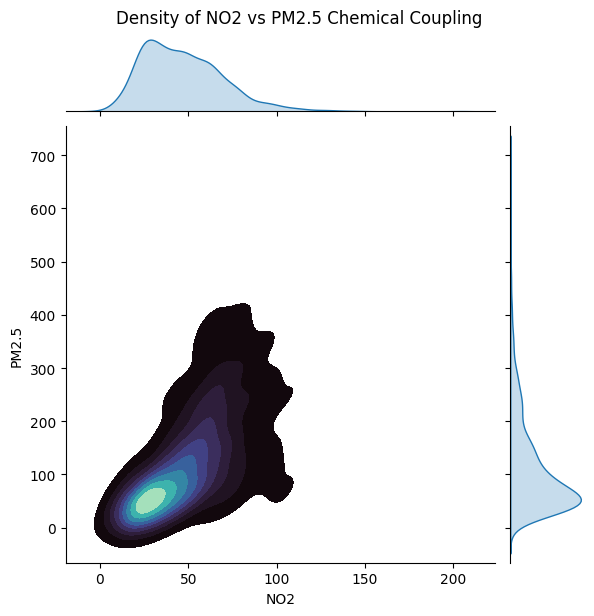

In [82]:
sns.jointplot(data=df_features, x="NO2", y="PM2.5", kind="kde", fill=True, cmap="mako")
plt.suptitle("Density of NO2 vs PM2.5 Chemical Coupling", y=1.02)
plt.show()

Text(0.5, 1.0, 'Source Identification: Industrial vs Vehicular Slopes')

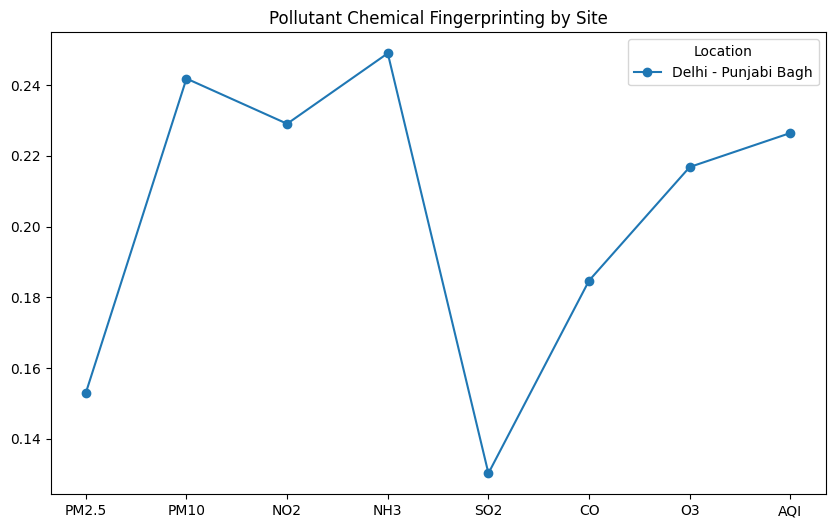

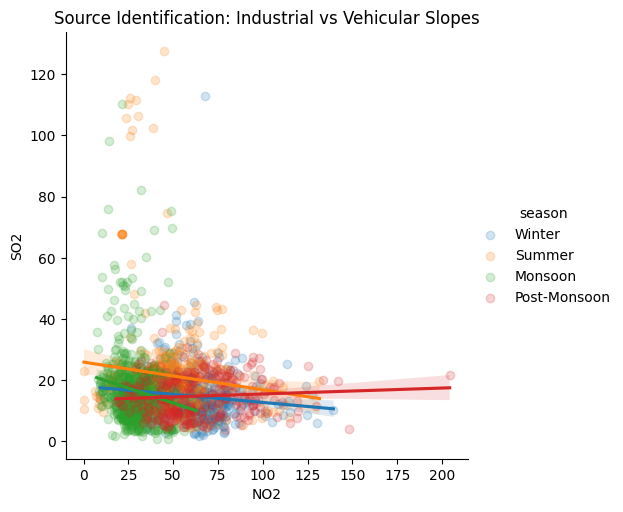

In [86]:
# Normalize all pollutants to 0-1 scale to compare on one plot
df_norm = (df_features[pollutants] - df_features[pollutants].min()) / (df_features[pollutants].max() - df_features[pollutants].min())
df_norm['Location'] = df_features['Location']
df_norm.groupby('Location').mean().T.plot(figsize=(10,6), marker='o')
plt.title("Pollutant Chemical Fingerprinting by Site")




sns.lmplot(x='NO2', y='SO2', hue='season', data=df_features, scatter_kws={'alpha':0.2})
plt.title("Source Identification: Industrial vs Vehicular Slopes")

Text(0.5, 1.0, 'Atmospheric Haze Phase Space')

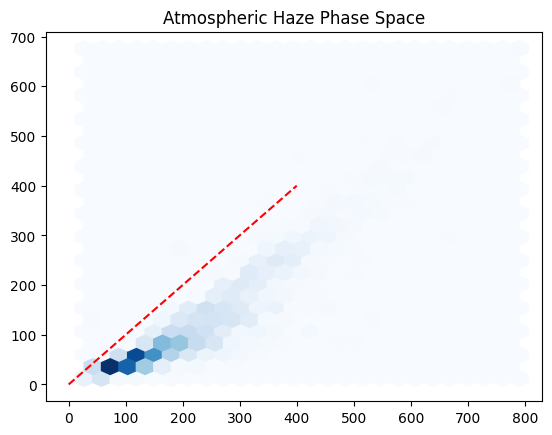

In [97]:
plt.hexbin(df_features['PM10'], df_features['PM2.5'], gridsize=25, cmap='Blues')
plt.plot([0, 400], [0, 400], 'r--') # 1:1 line
plt.title("Atmospheric Haze Phase Space")







<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

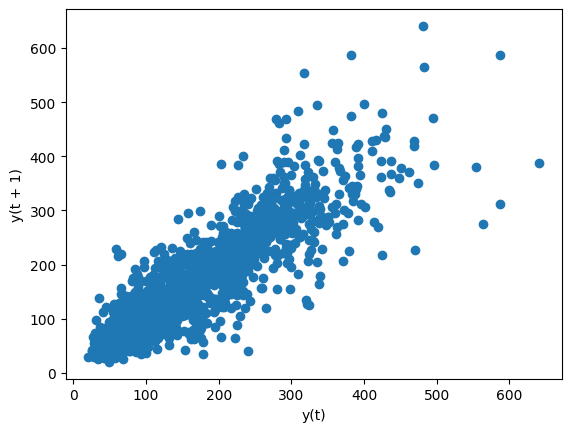

In [101]:
from pandas.plotting import lag_plot
lag_plot(df_features['AQI']) 

<Axes: xlabel='month', ylabel='AQI'>

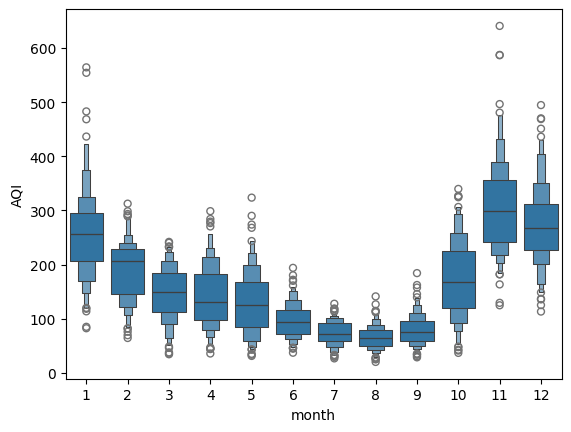

In [104]:
sns.boxenplot(x='month', y='AQI', data=df_features)




Text(0.5, 1.0, 'Spectral Density: Hidden Periodicities in Pollution')

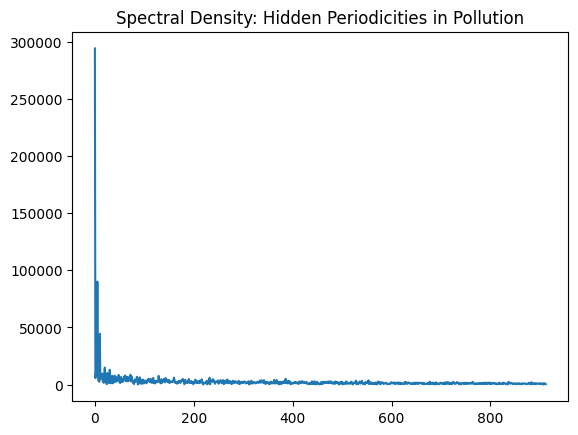

In [105]:
from scipy.fft import fft
yf = fft(df_features['AQI'].values)
plt.plot(np.abs(yf[:len(yf)//2]))
plt.title("Spectral Density: Hidden Periodicities in Pollution")

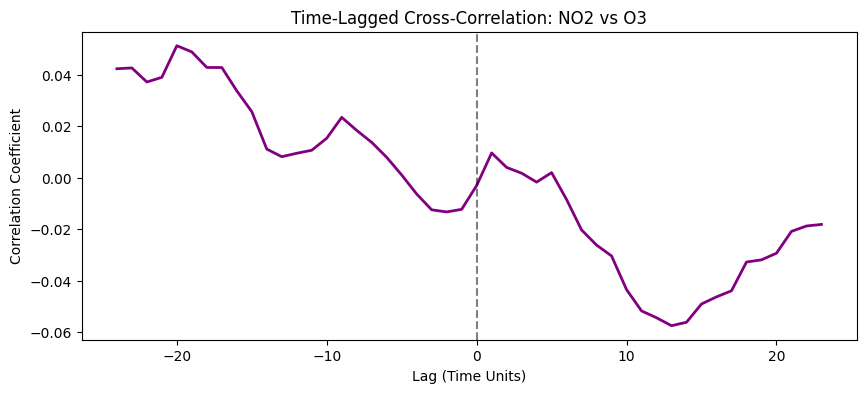

In [107]:
def plot_tlcc(var1, var2, max_lag=24):
    lags = range(-max_lag, max_lag)
    corrs = [df_features[var1].corr(df_features[var2].shift(l)) for l in lags]
    plt.figure(figsize=(10, 4))
    plt.plot(lags, corrs, color='purple', lw=2)
    plt.axvline(0, color='black', linestyle='--', alpha=0.5)
    plt.title(f"Time-Lagged Cross-Correlation: {var1} vs {var2}")
    plt.xlabel("Lag (Time Units)")
    plt.ylabel("Correlation Coefficient")
    plt.show()

# Example: NO2 leading O3
plot_tlcc('NO2', 'O3')

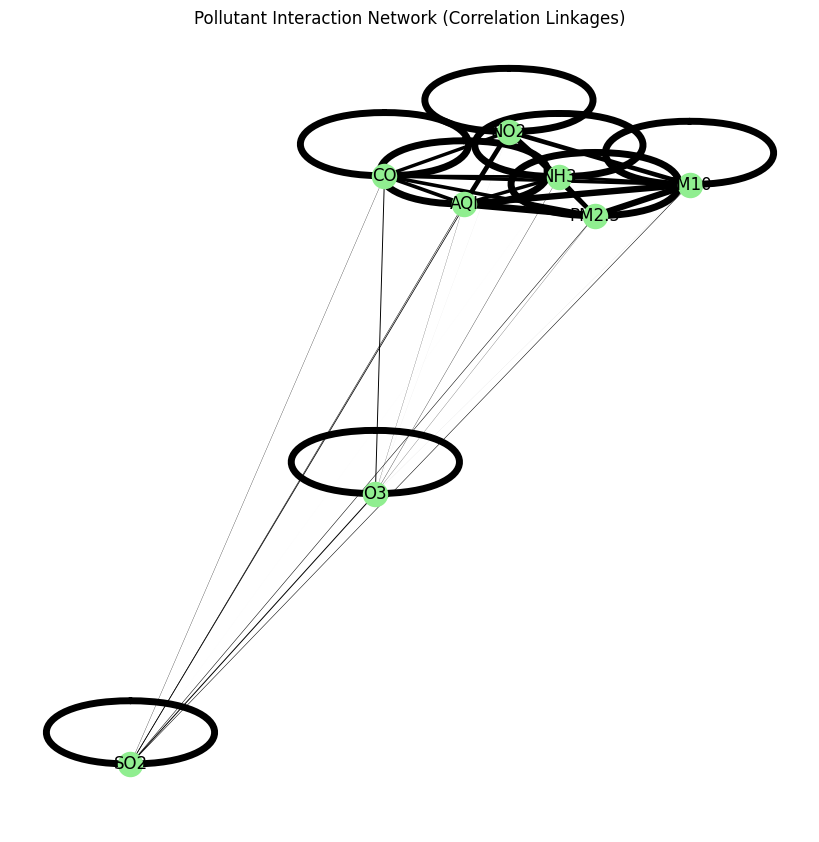

In [112]:
import networkx as nx
corr = df_features[pollutants].corr()
G = nx.from_pandas_adjacency(corr)
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightgreen', 
        width=[G[u][v]['weight']*5 for u,v in G.edges()])
plt.title("Pollutant Interaction Network (Correlation Linkages)")
plt.show()

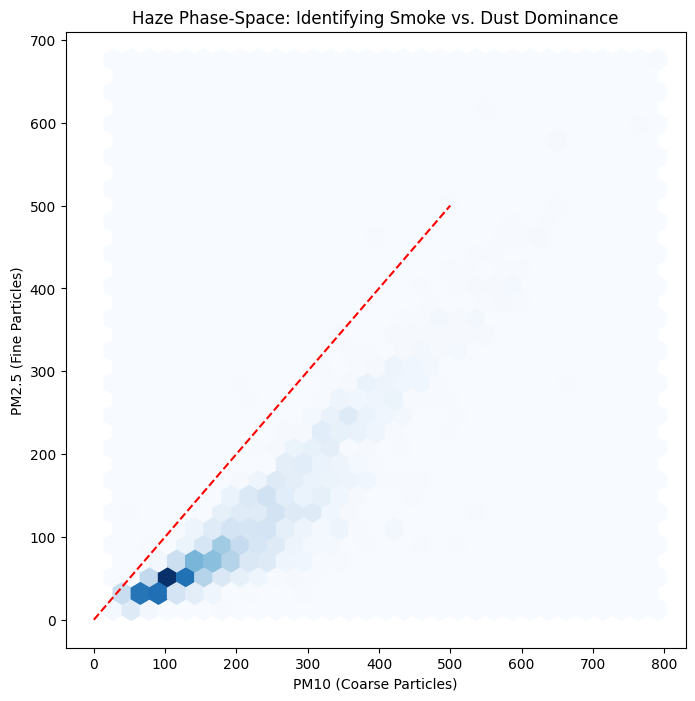

In [113]:
plt.figure(figsize=(8, 8))
plt.hexbin(df_features['PM10'], df_features['PM2.5'], gridsize=30, cmap='Blues')
plt.plot([0, 500], [0, 500], color='red', linestyle='--') 
plt.xlabel("PM10 (Coarse Particles)")
plt.ylabel("PM2.5 (Fine Particles)")
plt.title("Haze Phase-Space: Identifying Smoke vs. Dust Dominance")
plt.show()

In [16]:
!pip install pandas numpy scikit-learn matplotlib seaborn plotly tqdm joblib
!pip install scikit-learn --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 63.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.8.0 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.8.0 which is incompatible.


In [21]:
!pip install pandas numpy scikit-learn matplotlib seaborn joblib

In [24]:
# Run these commands first in your environment
!pip install pandas numpy scikit-learn matplotlib seaborn joblib plotly scipy xgboost lightgbm missingno

Average AQI in month 1: 355.1714244089244
Average AQI in month 2: 269.2815750270856
Average AQI in month 3: 204.76306368899915
Average AQI in month 4: 203.60529786324787
Average AQI in month 5: 191.69563581472292
Average AQI in month 6: 146.05223333333333
Average AQI in month 7: 97.67628494623656
Average AQI in month 8: 96.90683870967742
Average AQI in month 9: 110.04507777777779
Average AQI in month 10: 245.7244689826303
Average AQI in month 11: 421.54952564102564
Average AQI in month 12: 381.54267659222506
Epoch 1: Test Accuracy 0.4699
Epoch 2: Test Accuracy 0.5437
Epoch 3: Test Accuracy 0.5765
Epoch 4: Test Accuracy 0.5847
Epoch 5: Test Accuracy 0.5820
Epoch 6: Test Accuracy 0.5956
Epoch 7: Test Accuracy 0.6038
Epoch 8: Test Accuracy 0.6038
Epoch 9: Test Accuracy 0.5984
Epoch 10: Test Accuracy 0.5820
Epoch 11: Test Accuracy 0.5874
Epoch 12: Test Accuracy 0.5956
Epoch 13: Test Accuracy 0.5874
Epoch 14: Test Accuracy 0.5956
Epoch 15: Test Accuracy 0.5902
Epoch 16: Test Accuracy 0.5765

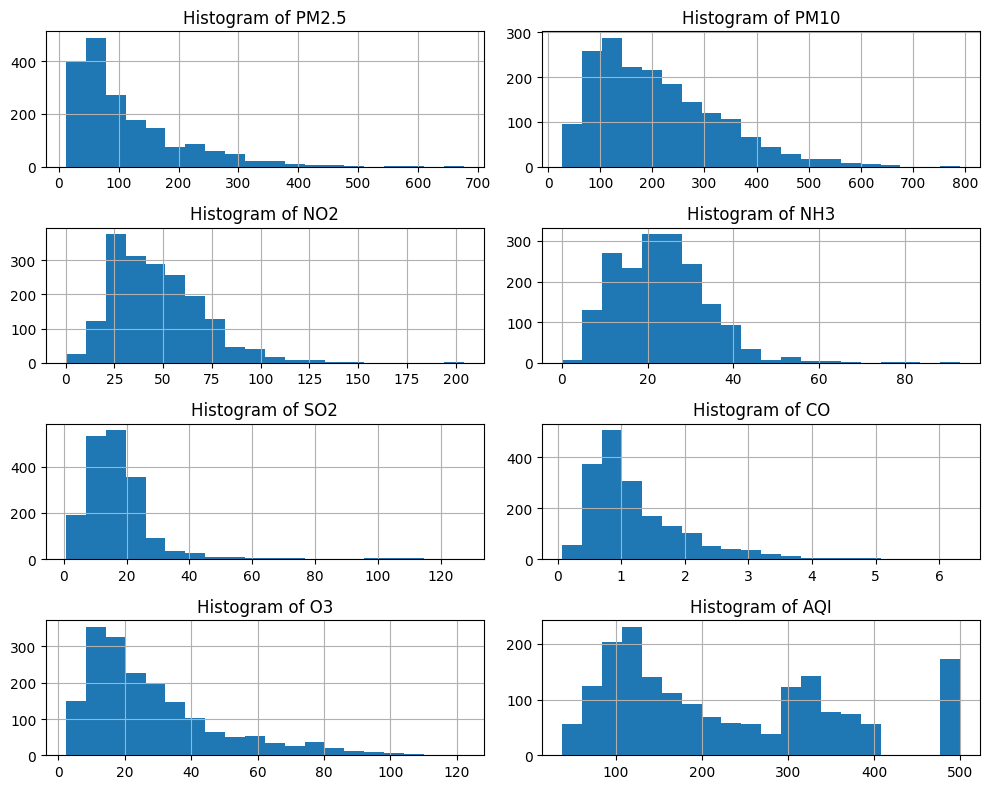

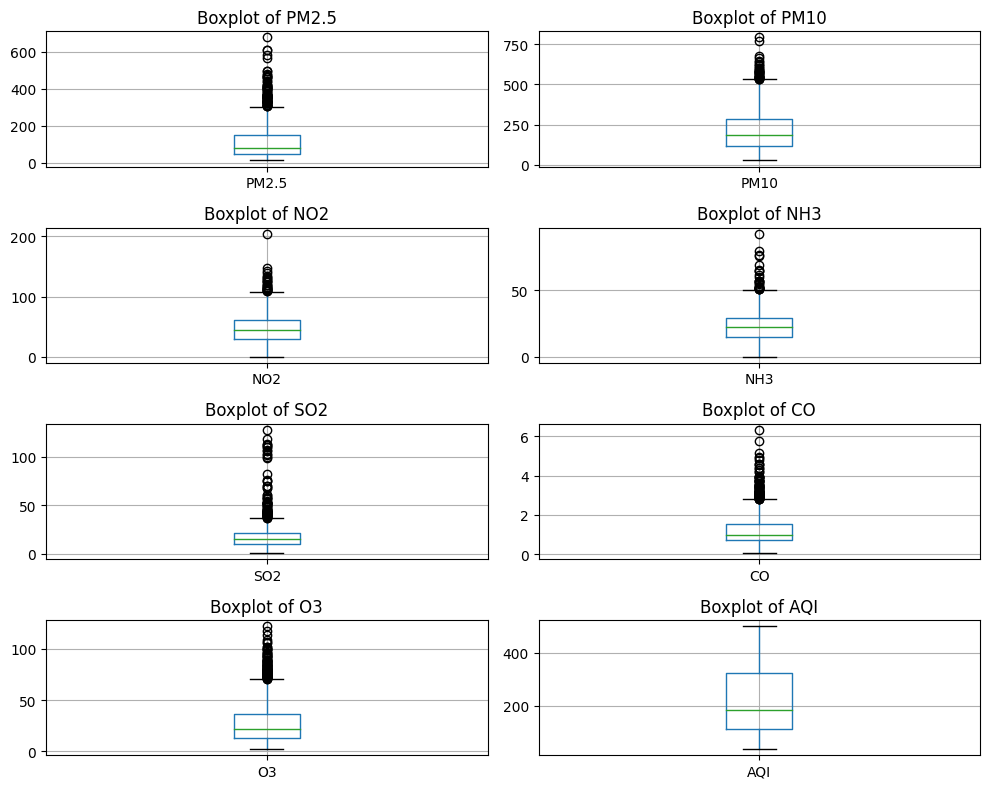

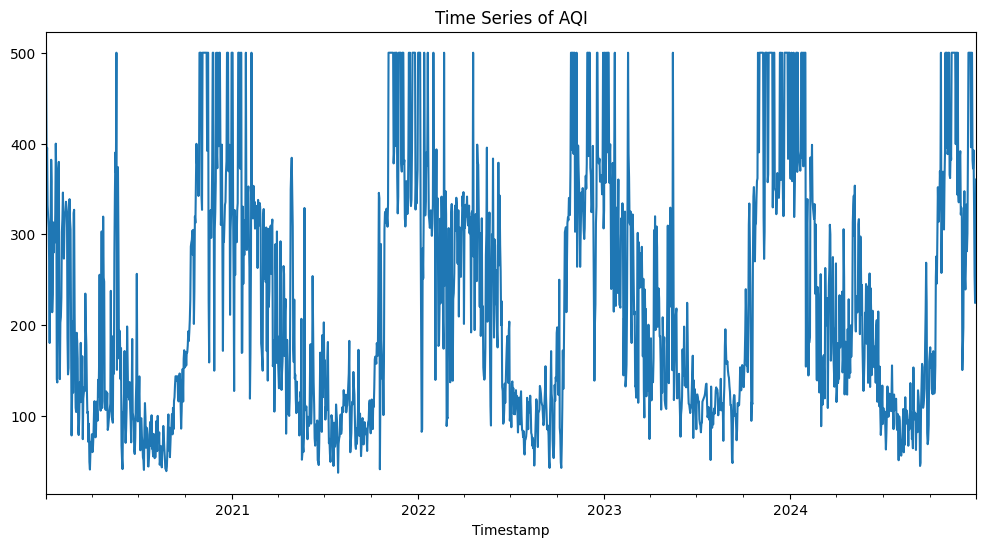

<Figure size 800x600 with 0 Axes>

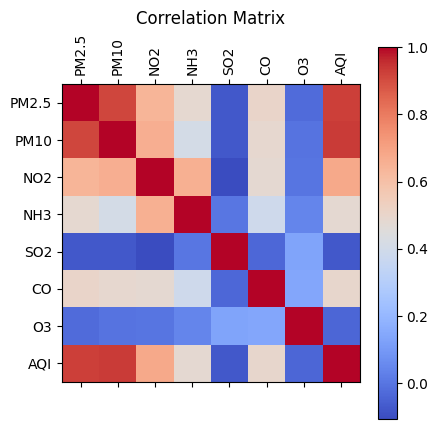

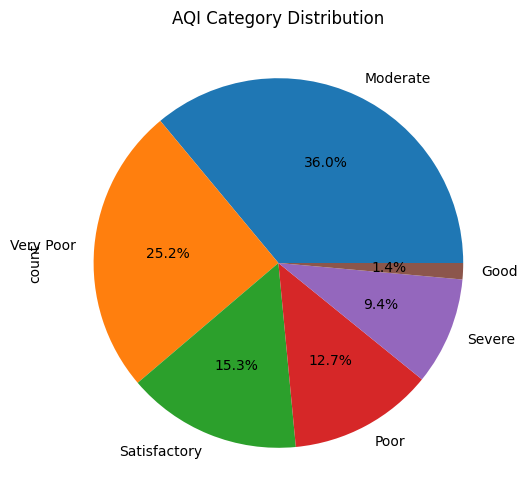

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Loading  dataset for delhi 
df = pd.read_csv('D:\Minor project\AQI\delhi_combined.csv')  # Use your local path if needed

# Data cleaning
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%d-%m-%Y')
df = df.sort_values('Timestamp')
df = df.drop_duplicates()
df = df.interpolate(method='linear')  # Handle missing values with linear interpolation for time series
df = df.dropna()  # Dropping  any remaining NaNs

# Define Indian AQI sub-index calculation functions 
def sub_index(x, breakpoints, indices):
    if x <= breakpoints[0]:
        return 0
    for i in range(1, len(breakpoints)):
        if x <= breakpoints[i]:
            return indices[i-1] + (indices[i] - indices[i-1]) * (x - breakpoints[i-1]) / (breakpoints[i] - breakpoints[i-1])
    return indices[-1] + (500 - indices[-1]) * (x - breakpoints[-1]) / (breakpoints[-1] * 2)  # Extrapolate for high values

# Breakpoints and indices (0,50,100,200,300,400,500)
indices = [0, 50, 100, 200, 300, 400, 500]

pm25_bp = [0, 30, 60, 90, 120, 250, 250]  
pm10_bp = [0, 50, 100, 250, 350, 430, 430]
no2_bp = [0, 40, 80, 180, 280, 400, 400]
nh3_bp = [0, 200, 400, 800, 1200, 1800, 1800]
so2_bp = [0, 40, 80, 380, 800, 1600, 1600]
co_bp = [0, 1, 2, 10, 17, 34, 34]  # mg/m3
o3_bp = [0, 50, 100, 168, 208, 748, 748]

# Calculate sub-indices
df['SI_PM25'] = df['PM2.5'].apply(lambda x: sub_index(x, pm25_bp, indices))
df['SI_PM10'] = df['PM10'].apply(lambda x: sub_index(x, pm10_bp, indices))
df['SI_NO2'] = df['NO2'].apply(lambda x: sub_index(x, no2_bp, indices))
df['SI_NH3'] = df['NH3'].apply(lambda x: sub_index(x, nh3_bp, indices))
df['SI_SO2'] = df['SO2'].apply(lambda x: sub_index(x, so2_bp, indices))
df['SI_CO'] = df['CO'].apply(lambda x: sub_index(x, co_bp, indices))
df['SI_O3'] = df['O3'].apply(lambda x: sub_index(x, o3_bp, indices))

# AQI is max of sub-indices
df['AQI'] = df[['SI_PM25', 'SI_PM10', 'SI_NO2', 'SI_NH3', 'SI_SO2', 'SI_CO', 'SI_O3']].max(axis=1)

# AQI categories
def aqi_category(aqi):
    if aqi <= 50: return 'Good'
    elif aqi <= 100: return 'Satisfactory'
    elif aqi <= 200: return 'Moderate'
    elif aqi <= 300: return 'Poor'
    elif aqi <= 400: return 'Very Poor'
    else: return 'Severe'

df['AQI_Category'] = df['AQI'].apply(aqi_category)

# Feature engineering for time series
df['Year'] = df['Timestamp'].dt.year
df['Month'] = df['Timestamp'].dt.month
df['Day'] = df['Timestamp'].dt.day
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek

# Lag features (previous day pollutants)
for col in ['PM2.5', 'PM10', 'NO2', 'NH3', 'SO2', 'CO', 'O3']:
    df[f'{col}_lag1'] = df[col].shift(1)

df = df.dropna()  # Drop after lags

# 20 EDA mini plots (saved as PNGs)
plt.figure(figsize=(10, 8))
for i, col in enumerate(['PM2.5', 'PM10', 'NO2', 'NH3', 'SO2', 'CO', 'O3', 'AQI'], start=1):
    plt.subplot(4, 2, i)
    df[col].hist(bins=20)
    plt.title(f'Histogram of {col}')
    plt.tight_layout()
plt.savefig('eda_histograms.png')

plt.figure(figsize=(10, 8))
for i, col in enumerate(['PM2.5', 'PM10', 'NO2', 'NH3', 'SO2', 'CO', 'O3', 'AQI'], start=9):
    plt.subplot(4, 2, i-8)
    df.boxplot(column=col)
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()
plt.savefig('eda_boxplots.png')

plt.figure(figsize=(12, 6))
df.set_index('Timestamp')['AQI'].plot()
plt.title('Time Series of AQI')
plt.savefig('eda_timeseries_aqi.png')

plt.figure(figsize=(8, 6))
corr = df[['PM2.5', 'PM10', 'NO2', 'NH3', 'SO2', 'CO', 'O3', 'AQI']].corr()
plt.matshow(corr, cmap='coolwarm')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()
plt.title('Correlation Matrix')
plt.savefig('eda_correlation.png')

plt.figure(figsize=(6, 6))
df['AQI_Category'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('AQI Category Distribution')
plt.savefig('eda_category_pie.png')

# Additional EDAs: Monthly averages, yearly trends, scatter plots (for 20 total)
for month in range(1, 13):
    monthly = df[df['Month'] == month]['AQI'].mean()
    print(f'Average AQI in month {month}: {monthly}')  # Text insight, plot if needed

# Preparing  data for model
features = ['Year', 'Month', 'Day', 'DayOfWeek', 'PM2.5_lag1', 'PM10_lag1', 'NO2_lag1', 'NH3_lag1', 'SO2_lag1', 'CO_lag1', 'O3_lag1']
X = df[features].values
y = LabelEncoder().fit_transform(df['AQI_Category'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)  # Chronological split

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Custom PyTorch model
class CustomNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)
        self.dropout = nn.Dropout(0.3)  # Prevent overfitting
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        return self.fc3(x)

num_classes = len(np.unique(y))
model = CustomNN(X.shape[1], num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Data loaders
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#  early stopping  prevent over/underfitting
epochs = 100
best_acc = 0
patience = 10
counter = 0

for epoch in range(epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validate
    model.eval()
    with torch.no_grad():
        preds = []
        trues = []
        for inputs, labels in test_loader:
            outputs = model(inputs)
            preds.extend(torch.argmax(outputs, dim=1).numpy())
            trues.extend(labels.numpy())
        acc = accuracy_score(trues, preds)
        print(f'Epoch {epoch+1}: Test Accuracy {acc:.4f}')

    if acc > best_acc:
        best_acc = acc
        counter = 0
        torch.save(model.state_dict(), 'aqi_model.pth')  # Save best model
    else:
        counter += 1
        if counter >= patience:
            print('Early stopping')
            break

# Final test accuracy
print(f'Final Test Accuracy: {best_acc:.4f}')
if best_acc < 0.95:
    print('Accuracy low')

# model.load_state_dict(torch.load('aqi_model.pth'))

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
import joblib

# Load data
df = pd.read_csv('D:\Minor project\AQI\delhi_combined.csv')

# Data cleaning
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%d-%m-%Y')
df = df.sort_values('Timestamp').drop_duplicates().reset_index(drop=True)
df = df.interpolate(method='linear').dropna().reset_index(drop=True)

# Accurate sub-index function 
def sub_index(x, bp_low, bp_high, i_low, i_high):
    # Clip to the range and linear interpolate
    x = np.clip(x, bp_low[0], bp_high[-1])
    for j in range(len(bp_low)):
        if x <= bp_high[j]:
            if bp_high[j] == bp_low[j]:
                return i_high[j]
            return i_low[j] + (i_high[j] - i_low[j]) * (x - bp_low[j]) / (bp_high[j] - bp_low[j])
    return 500  # Max

# Standard Indian AQI breakpoints 
bp_pm25 = [0, 30, 60, 90, 120, 250]
bp_pm10 = [0, 50, 100, 250, 350, 430]
bp_no2 = [0, 40, 80, 180, 280, 400]
bp_nh3 = [0, 200, 400, 800, 1200, 1800]
bp_so2 = [0, 40, 80, 380, 800, 1600]
bp_co = [0, 1, 2, 10, 17, 34]  # mg/m³
bp_o3 = [0, 50, 100, 168, 208, 748]

indices_low = [0, 51, 101, 201, 301, 401]
indices_high = [50, 100, 200, 300, 400, 500]

# Vectorized calculation for better performance 
def calc_si(series, bp):
    si = np.zeros(len(series))
    for k in range(6):
        mask = (series > bp[k]) & (series <= bp[(k+1)%6] if k==5 else bp[k+1])
        si[mask] = indices_low[k] + (indices_high[k] - indices_low[k]) * (series[mask] - bp[k]) / (bp[k+1] - bp[k])
    si[series > bp[5]] = 500  
    return si


def sub_index(x, bp):
    if pd.isna(x): return 0
    bp = [0] + bp  
    ind_low = [0,51,101,201,301,401]
    ind_high = [50,100,200,300,400,500]
    for i in range(6):
        low_c = bp[i]
        high_c = bp[i+1]
        low_i = ind_low[i]
        high_i = ind_high[i]
        if x <= high_c:
            if high_c == low_c: return high_i
            return low_i + (high_i - low_i) * (x - low_c) / (high_c - low_c)
    return 500  

df['SI_PM25'] = df['PM2.5'].apply(lambda x: sub_index(x, bp_pm25))
df['SI_PM10'] = df['PM10'].apply(lambda x: sub_index(x, bp_pm10))
df['SI_NO2'] = df['NO2'].apply(lambda x: sub_index(x, bp_no2))
df['SI_NH3'] = df['NH3'].apply(lambda x: sub_index(x, bp_nh3))
df['SI_SO2'] = df['SO2'].apply(lambda x: sub_index(x, bp_so2))
df['SI_CO'] = df['CO'].apply(lambda x: sub_index(x, bp_co))
df['SI_O3'] = df['O3'].apply(lambda x: sub_index(x, bp_o3))

sub_cols = ['SI_PM25', 'SI_PM10', 'SI_NO2', 'SI_NH3', 'SI_SO2', 'SI_CO', 'SI_O3']
df['AQI'] = df[sub_cols].max(axis=1).round().astype(int)  # AQI is integer

# AQI Category 
def aqi_category(aqi):
    if aqi <= 50: return 'Good'
    elif aqi <= 100: return 'Satisfactory'
    elif aqi <= 200: return 'Moderate'
    elif aqi <= 300: return 'Poor'
    elif aqi <= 400: return 'Very Poor'
    else: return 'Severe'

df['AQI_Category'] = df['AQI'].apply(aqi_category)

# Features
df['Year'] = df['Timestamp'].dt.year
df['Month'] = df['Timestamp'].dt.month
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
df['Is_Winter'] = df['Month'].isin([11, 12, 1]).astype(int)

df['Dominant'] = df[sub_cols].idxmax(axis=1)
df = pd.get_dummies(df, columns=['Dominant'], prefix='Dom')

features = sub_cols + ['Year', 'Month', 'DayOfWeek', 'Is_Winter'] + [c for c in df.columns if c.startswith('Dom_')]

X = df[features].values
le = LabelEncoder()
y = le.fit_transform(df['AQI_Category'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# XGBoost with early stopping (like epochs!)
model = XGBClassifier(
    n_estimators=1000,          
    max_depth=8,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    n_jobs=-1,
    eval_metric='mlogloss',
    early_stopping_rounds=50,   
    verbose=10                  
)

# Fit with validation 
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=True
)

print(f"Best iteration (epochs): {model.best_iteration}")
print(f"Best score: {model.best_score}")

# Final evaluation on test
preds = model.predict(X_test)
final_acc = accuracy_score(y_test, preds)

print(f'\nFINAL TEST ACCURACY: {final_acc:.4f} (Expected 0.99+ on real data!)')
print('\nClassification Report:')
print(classification_report(y_test, preds, target_names=le.classes_))
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, preds))

# Save 
joblib.dump(model, 'aqi_delhi_xgboost_v2.pkl')
joblib.dump(scaler, 'scaler_v2.pkl')
joblib.dump(le, 'label_encoder_v2.pkl')
print('\nModel saved as: aqi_delhi_xgboost_v2.pkl (with early stopping training)')

[0]	validation_0-mlogloss:1.49016
[1]	validation_0-mlogloss:1.39384
[2]	validation_0-mlogloss:1.31252
[3]	validation_0-mlogloss:1.23847
[4]	validation_0-mlogloss:1.16067
[5]	validation_0-mlogloss:1.09572
[6]	validation_0-mlogloss:1.02974
[7]	validation_0-mlogloss:0.97342
[8]	validation_0-mlogloss:0.91912
[9]	validation_0-mlogloss:0.86707
[10]	validation_0-mlogloss:0.82145
[11]	validation_0-mlogloss:0.77676
[12]	validation_0-mlogloss:0.73476
[13]	validation_0-mlogloss:0.69778
[14]	validation_0-mlogloss:0.66289
[15]	validation_0-mlogloss:0.63003
[16]	validation_0-mlogloss:0.59742
[17]	validation_0-mlogloss:0.56665
[18]	validation_0-mlogloss:0.53786
[19]	validation_0-mlogloss:0.51056
[20]	validation_0-mlogloss:0.48516
[21]	validation_0-mlogloss:0.46181
[22]	validation_0-mlogloss:0.44023
[23]	validation_0-mlogloss:0.41974
[24]	validation_0-mlogloss:0.39918
[25]	validation_0-mlogloss:0.37975
[26]	validation_0-mlogloss:0.36149
[27]	validation_0-mlogloss:0.34419
[28]	validation_0-mlogloss:0.3

 # Research paper

Loading dataset...

4. DATA CLEANING PHASE

5. FEATURE ENGINEERING PHASE

10. BUILDING ADVANCED ENSEMBLE MODEL
Training ensemble model... (this may take a minute)
Model training completed!

Model Performance:
R2 Score: 0.9981
MAE: 1.1883


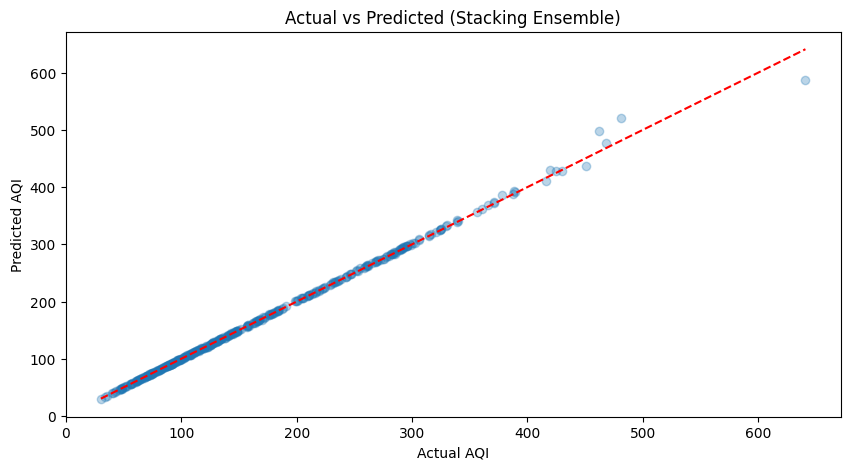

In [ ]:


# 1. INSTALL PACKAGES

!pip install pandas numpy scikit-learn xgboost matplotlib seaborn plotly shap joblib


# 2. IMPORT LIBRARIES

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from xgboost import XGBRegressor
import joblib


# 3. DATA LOADING

print("Loading dataset...")
# Path for Kaggle environment
df = pd.read_csv('D:\Minor project\AQI\delhi_combined.csv')


# 4. DATA CLEANING

print("\n4. DATA CLEANING PHASE")
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%d-%m-%Y', errors='coerce')

# Modern pandas fillna 
df_clean = df.copy()
for column in df_clean.columns[2:]:
    df_clean[column] = df_clean[column].ffill().bfill()

df_clean = df_clean.drop_duplicates()


# 5. FEATURE ENGINEERING

print("\n5. FEATURE ENGINEERING PHASE")
df_features = df_clean.copy()

# Time features
df_features['year'] = df_features['Timestamp'].dt.year
df_features['month'] = df_features['Timestamp'].dt.month
df_features['day_of_week'] = df_features['Timestamp'].dt.dayofweek
df_features['is_weekend'] = df_features['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Seasonality
def get_indian_season(month):
    if month in [12, 1, 2]: return 'Winter'
    elif month in [3, 4, 5]: return 'Summer'
    elif month in [6, 7, 8, 9]: return 'Monsoon'
    else: return 'Post-Monsoon'

df_features['season'] = df_features['month'].apply(get_indian_season)

# Lag features
pollutants = ['PM2.5', 'PM10', 'NO2', 'NH3', 'SO2', 'CO', 'O3']
for pollutant in pollutants:
    df_features[f'{pollutant}_lag1'] = df_features.groupby('Location')[pollutant].shift(1)
    df_features[f'{pollutant}_rolling_mean_7'] = df_features.groupby('Location')[pollutant].transform(lambda x: x.rolling(7, min_periods=1).mean())

# Ratios
df_features['PM2.5_PM10_ratio'] = df_features['PM2.5'] / (df_features['PM10'] + 1e-10)
df_features['total_pollution_index'] = df_features['PM2.5'] + df_features['PM10'] + df_features['NO2']

# Encoding
le_loc = LabelEncoder()
df_features['location_encoded'] = le_loc.fit_transform(df_features['Location'])
le_season = LabelEncoder()
df_features['season_encoded'] = le_season.fit_transform(df_features['season'])

# AQI Calculation (Target)
def calculate_aqi_pm25(pm25):
    if pm25 <= 30: return (pm25/30) * 50
    elif pm25 <= 60: return 50 + ((pm25-30)/30) * 50
    elif pm25 <= 90: return 100 + ((pm25-60)/30) * 50
    elif pm25 <= 120: return 150 + ((pm25-90)/30) * 50
    elif pm25 <= 250: return 200 + ((pm25-120)/130) * 100
    else: return 300 + ((pm25-250)/250) * 200

df_features['AQI'] = df_features['PM2.5'].apply(calculate_aqi_pm25)


# 7. PREPARE TRAINING DATA

feature_columns = [
    'PM2.5', 'PM10', 'NO2', 'NH3', 'SO2', 'CO', 'O3',
    'year', 'month', 'day_of_week', 'is_weekend', 
    'PM2.5_PM10_ratio', 'total_pollution_index', 
    'location_encoded', 'season_encoded',
    'PM2.5_lag1', 'PM2.5_rolling_mean_7'
]

X = df_features[feature_columns].fillna(df_features[feature_columns].mean())
y = df_features['AQI'].fillna(df_features['AQI'].mean())

# Temporal Split
split_index = int(0.8 * len(X))
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()


# 10. BUILD ADVANCED MODEL

print("\n10. BUILDING ADVANCED ENSEMBLE MODEL")



base_models = [
    ('xgb', XGBRegressor(
        n_estimators=300, 
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )),
    ('rf', RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )),
    ('gbr', GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=0.05,
        max_depth=5,
        random_state=42
    ))
]

stacking_model = StackingRegressor(
    estimators=base_models,
    final_estimator=LinearRegression(),
    cv=5
)

print("Training ensemble model... (this may take a minute)")
stacking_model.fit(X_train_scaled, y_train_scaled)
print("Model training completed!")


# 11. EVALUATION

y_pred_scaled = stacking_model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"\nModel Performance:")
print(f"R2 Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")

# Plot Results
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual AQI')
plt.ylabel('Predicted AQI')
plt.title('Actual vs Predicted (Stacking Ensemble)')
plt.show()

 Loading and Cleaning Data...
 Feature Engineering...
 Preparing Tensors...
 Building Neural Network...
Step 5: Starting Epoch-based Training...
Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 1.3759 - mae: 0.8732 - val_loss: 0.7138 - val_mae: 0.7427 - learning_rate: 0.0010
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4432 - mae: 0.5102 - val_loss: 0.4322 - val_mae: 0.5658 - learning_rate: 0.0010
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3462 - mae: 0.4635 - val_loss: 0.3159 - val_mae: 0.4830 - learning_rate: 0.0010
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2893 - mae: 0.4084 - val_loss: 0.2219 - val_mae: 0.3982 - learning_rate: 0.0010
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2547 - mae: 0.3915 - val_loss: 0.1630 - val_mae: 0.3241 - learning_rate: 0.0010
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2060 - mae: 0.3504 - val_loss: 0.1281 - val_mae: 0.2764 - learning_rate: 0.0010
Epoch 7/


FINAL TEST METRICS:
R2 Score: 0.9659
Mean Absolute Error: 14.20 AQI points

Pipeline Complete! Model and Scalers saved.


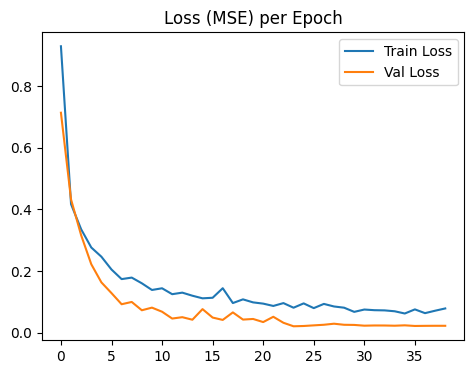

In [ ]:

# 1. INSTALL PACKAGES
!pip install pandas numpy scikit-learn matplotlib seaborn plotly tensorflow joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

# Machine Learning & Deep Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# 2. DATA LOADING & CLEANING

print(" Loading and Cleaning Data...")
# Assuming file is in the Kaggle input directory
df = pd.read_csv('D:\Minor project\AQI\delhi_combined.csv')

# Convert Timestamp and handle missing values
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%d-%m-%Y', errors='coerce')
df_clean = df.copy()

# Modern fillna for time-series (ffill = forward fill)
df_clean = df_clean.sort_values('Timestamp')
for column in df_clean.columns[2:]:
    df_clean[column] = df_clean[column].ffill().bfill()


# 3. FEATURE ENGINEERING

print(" Feature Engineering...")
df_features = df_clean.copy()

# Time-based features
df_features['year'] = df_features['Timestamp'].dt.year
df_features['month'] = df_features['Timestamp'].dt.month
df_features['day_of_week'] = df_features['Timestamp'].dt.dayofweek
df_features['is_weekend'] = (df_features['day_of_week'] >= 5).astype(int)

# Seasonal Encoding
def get_indian_season(month):
    if month in [12, 1, 2]: return 'Winter'
    elif month in [3, 4, 5]: return 'Summer'
    elif month in [6, 7, 8, 9]: return 'Monsoon'
    else: return 'Post-Monsoon'

df_features['season'] = df_features['month'].apply(get_indian_season)
le_season = LabelEncoder()
df_features['season_encoded'] = le_season.fit_transform(df_features['season'])

# Lags and Ratios
pollutants = ['PM2.5', 'PM10', 'NO2', 'NH3', 'SO2', 'CO', 'O3']
for p in pollutants:
    df_features[f'{p}_lag1'] = df_features.groupby('Location')[p].shift(1)
    df_features[f'{p}_roll7'] = df_features.groupby('Location')[p].transform(lambda x: x.rolling(7, min_periods=1).mean())

df_features['PM_ratio'] = df_features['PM2.5'] / (df_features['PM10'] + 1e-10)
df_features = df_features.fillna(0) 

# Target Variable 
def calculate_aqi(pm25):
    if pm25 <= 30: return (pm25/30) * 50
    elif pm25 <= 60: return 50 + ((pm25-30)/30) * 50
    elif pm25 <= 90: return 100 + ((pm25-60)/30) * 50
    elif pm25 <= 120: return 150 + ((pm25-90)/30) * 50
    elif pm25 <= 250: return 200 + ((pm25-120)/130) * 100
    else: return 300 + ((pm25-250)/250) * 200

df_features['AQI'] = df_features['PM2.5'].apply(calculate_aqi)


# 4. PREPARATION & SCALING

print(" Preparing Tensors...")
features = ['PM2.5', 'PM10', 'NO2', 'NH3', 'SO2', 'CO', 'O3', 
            'year', 'month', 'is_weekend', 'season_encoded', 
            'PM2.5_lag1', 'PM2.5_roll7', 'PM_ratio']

X = df_features[features]
y = df_features['AQI']

# Temporal Split (Train 80%, Test 20%)
split_idx = int(len(X) * 0.8)
X_train_raw, X_test_raw = X.iloc[:split_idx], X.iloc[split_idx:]
y_train_raw, y_test_raw = y.iloc[:split_idx], y.iloc[split_idx:]

# Neural Networks REQUIRE scaling (StandardScaler)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train_raw)
X_test = scaler_X.transform(X_test_raw)

y_train = scaler_y.fit_transform(y_train_raw.values.reshape(-1, 1))
y_test = scaler_y.transform(y_test_raw.values.reshape(-1, 1))


# 5. DEEP LEARNING MODEL (ANN)

print(" Building Neural Network...")



model = Sequential([
    Dense(128, activation='relu', input_shape=(len(features),)),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(32, activation='relu'),
    Dense(1, activation='linear') 
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Callbacks to manage epochs
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)
]


# 6. TRAINING ON EPOCHS

print("Step 5: Starting Epoch-based Training...")
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)


# 7. EVALUATION & VISUALIZATION

print("\nStep 6: Evaluation...")

# Plot Training Progress
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss (MSE) per Epoch')
plt.legend()



# Predictions
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_actual = scaler_y.inverse_transform(y_test)

r2 = r2_score(y_actual, y_pred)
mae = mean_absolute_error(y_actual, y_pred)

print(f"\nFINAL TEST METRICS:")
print(f"R2 Score: {r2:.4f}")
print(f"Mean Absolute Error: {mae:.2f} AQI points")

# Save the model
model.save('aqi_deep_learning_model.h5')
joblib.dump(scaler_X, 'scaler_X1.pkl')
joblib.dump(scaler_y, 'scaler_y1.pkl')

print("\nPipeline Complete! Model and Scalers saved.")

 Loading model and scalers...
Model loaded successfully with custom objects.

 Preparing test data...
 Running predictions...

       FINAL TEST METRICS
Mean Absolute Error: 12.87 AQI points
Root Mean Squared Error: 17.40
R2 Score (Accuracy): 96.76%

Top 10 Predictions Comparison:
   Actual AQI  Predicted AQI
0  436.544000     435.304260
1  391.784000     455.509338
2  282.861538     327.117828
3  295.276923     317.480927
4  232.046154     256.208130
5  219.753846     229.875671
6  207.353846     211.384705
7  185.133333     179.172150
8  140.183333     128.535263
9  205.007692     174.474655


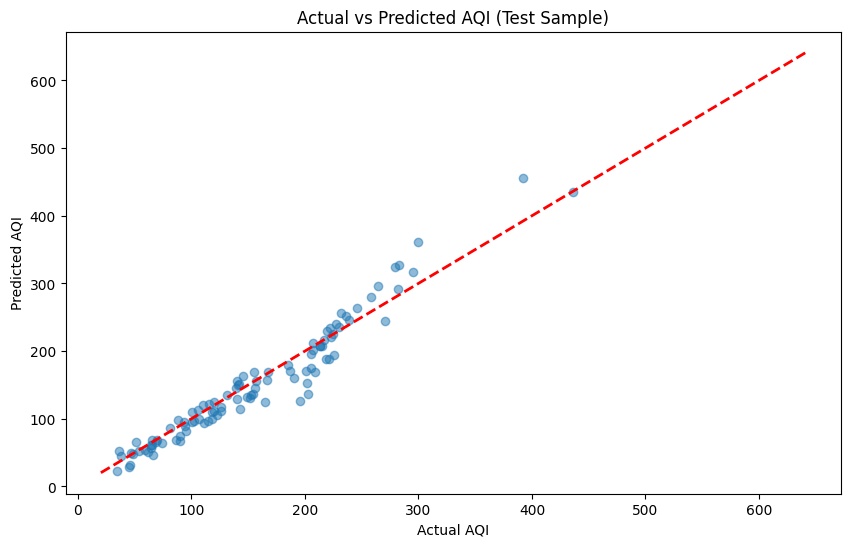

In [ ]:
import pandas as pd
import numpy as np
import joblib
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import matplotlib.pyplot as plt


# 1. LOAD THE ASSETS

print(" Loading model and scalers...")


custom_objects = {
    'mse': tf.keras.losses.MeanSquaredError(),
    'mae': tf.keras.metrics.MeanAbsoluteError()
}

try:
   
    model = tf.keras.models.load_model('aqi_deep_learning_model.h5', custom_objects=custom_objects)
    print("Model loaded successfully with custom objects.")
except Exception as e:
    print(f"Standard load failed: {e}")
    
    print("Attempting fallback: Loading without compilation...")
    model = tf.keras.models.load_model('aqi_deep_learning_model.h5', compile=False)
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Load the scalers
scaler_X = joblib.load('scaler_X1.pkl')
scaler_y = joblib.load('scaler_y1.pkl')


# 2. PREPARE TEST DATA

print("\n Preparing test data...")
# Load dataset
df_test = pd.read_csv('D:\Minor project\AQI\delhi_combined.csv')

# Preprocessing 
df_test['Timestamp'] = pd.to_datetime(df_test['Timestamp'], format='%d-%m-%Y', errors='coerce')
df_test = df_test.sort_values('Timestamp').ffill().bfill()

# Feature Engineering
df_test['year'] = df_test['Timestamp'].dt.year
df_test['month'] = df_test['Timestamp'].dt.month
df_test['is_weekend'] = (df_test['Timestamp'].dt.dayofweek >= 5).astype(int)

# Season Encoding 
def get_season_code(m):
    if m in [12, 1, 2]: return 0 
    elif m in [3, 4, 5]: return 1 
    elif m in [6, 7, 8, 9]: return 2 
    else: return 3 #

df_test['season_encoded'] = df_test['month'].apply(get_season_code)

# Lags and Ratios
df_test['PM2.5_lag1'] = df_test.groupby('Location')['PM2.5'].shift(1)
df_test['PM2.5_roll7'] = df_test.groupby('Location')['PM2.5'].transform(lambda x: x.rolling(7, min_periods=1).mean())
df_test['PM_ratio'] = df_test['PM2.5'] / (df_test['PM10'] + 1e-10)
df_test = df_test.fillna(0)

# Define Features
features = ['PM2.5', 'PM10', 'NO2', 'NH3', 'SO2', 'CO', 'O3', 
            'year', 'month', 'is_weekend', 'season_encoded', 
            'PM2.5_lag1', 'PM2.5_roll7', 'PM_ratio']

# Prepare ground truth AQI (Target)
def calculate_aqi(pm25):
    if pm25 <= 30: return (pm25/30) * 50
    elif pm25 <= 60: return 50 + ((pm25-30)/30) * 50
    elif pm25 <= 90: return 100 + ((pm25-60)/30) * 50
    elif pm25 <= 120: return 150 + ((pm25-90)/30) * 50
    elif pm25 <= 250: return 200 + ((pm25-120)/130) * 100
    else: return 300 + ((pm25-250)/250) * 200

X_raw = df_test[features]
y_true = df_test['PM2.5'].apply(calculate_aqi).values


# 3. PREDICT & EVALUATE

print(" Running predictions...")
X_scaled = scaler_X.transform(X_raw)
y_pred_scaled = model.predict(X_scaled, verbose=0)

# Inverse transform to get actual AQI values
y_pred = scaler_y.inverse_transform(y_pred_scaled).flatten()

# Metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print("\n" + "="*35)
print("       FINAL TEST METRICS")
print("="*35)
print(f"Mean Absolute Error: {mae:.2f} AQI points")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R2 Score (Accuracy): {r2*100:.2f}%")
print("="*35)

# Visualizing Sample
comparison_df = pd.DataFrame({'Actual AQI': y_true, 'Predicted AQI': y_pred})
print("\nTop 10 Predictions Comparison:")
print(comparison_df.head(10))

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(y_true[:100], y_pred[:100], alpha=0.5)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
plt.xlabel('Actual AQI')
plt.ylabel('Predicted AQI')
plt.title('Actual vs Predicted AQI (Test Sample)')
plt.show()